In [4]:
# Import các thư viện cần thiết
!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [5]:
# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# data (as pandas dataframes)
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

# metadata
print(cdc_diabetes_health_indicators.metadata)

# variable information
print(cdc_diabetes_health_indicators.variables)

# Combine features and targets into a single DataFrame
df = pd.concat([X, y], axis=1)

# Display the first few rows of the DataFrame
df.head()

{'uci_id': 891, 'name': 'CDC Diabetes Health Indicators', 'repository_url': 'https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators', 'data_url': 'https://archive.ics.uci.edu/static/public/891/data.csv', 'abstract': 'The Diabetes Health Indicators Dataset contains healthcare statistics and lifestyle survey information about people in general along with their diagnosis of diabetes. The 35 features consist of some demographics, lab test results, and answers to survey questions for each patient. The target variable for classification is whether a patient has diabetes, is pre-diabetic, or healthy. ', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 253680, 'num_features': 21, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Sex', 'Age', 'Education Level', 'Income'], 'target_col': ['Diabetes_binary'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
0,1,1,1,40,1,0,0,0,0,1,...,0,5,18,15,1,0,9,4,3,0
1,0,0,0,25,1,0,0,1,0,0,...,1,3,0,0,0,0,7,6,1,0
2,1,1,1,28,0,0,0,0,1,0,...,1,5,30,30,1,0,9,4,8,0
3,1,0,1,27,0,0,0,1,1,1,...,0,2,0,0,0,0,11,3,6,0
4,1,1,1,24,0,0,0,1,1,1,...,0,2,3,0,0,0,11,5,4,0


# **Mô tả bộ dữ liệu:**
---
##  **Thông tin chung**

* **ID**: Mã định danh duy nhất cho mỗi người tham gia khảo sát.

## **Biến mục tiêu**

* **Diabetes\_binary**: Biến mục tiêu phân loại:

  * `0`: Không mắc tiểu đường
  * `1`: Tiền tiểu đường hoặc tiểu đường

---

## **Các chỉ số sức khỏe và thói quen sống**
| Tên biến                 | Loại    | Mô tả                                                  | Giá trị             |
| ------------------------ | ------- | ------------------------------------------------------ | ------------------- |
| **HighBP**               | Binary  | Huyết áp cao                                           | `0`: Không, `1`: Có |
| **HighChol**             | Binary  | Mỡ máu cao (cholesterol)                               | `0`: Không, `1`: Có |
| **CholCheck**            | Binary  | Đã kiểm tra mỡ máu trong 5 năm qua                     | `0`: Không, `1`: Có |
| **BMI**                  | Integer | Chỉ số khối cơ thể (Body Mass Index)                   | Giá trị số          |
| **Smoker**               | Binary  | Đã hút ít nhất 100 điếu thuốc trong đời                | `0`: Không, `1`: Có |
| **Stroke**               | Binary  | Từng bị đột quỵ                                        | `0`: Không, `1`: Có |
| **HeartDiseaseorAttack** | Binary  | Bệnh tim mạch hoặc đau tim                             | `0`: Không, `1`: Có |
| **PhysActivity**         | Binary  | Có hoạt động thể chất trong 30 ngày qua                | `0`: Không, `1`: Có |
| **Fruits**               | Binary  | Ăn trái cây ≥ 1 lần/ngày                               | `0`: Không, `1`: Có |
| **Veggies**              | Binary  | Ăn rau ≥ 1 lần/ngày                                    | `0`: Không, `1`: Có |
| **HvyAlcoholConsump**    | Binary  | Uống rượu nhiều (Nam >14, Nữ >7 ly/tuần)               | `0`: Không, `1`: Có |
| **AnyHealthcare**        | Binary  | Có bảo hiểm hoặc tiếp cận dịch vụ y tế                 | `0`: Không, `1`: Có |
| **NoDocbcCost**          | Binary  | Không đi khám do chi phí trong 12 tháng qua            | `0`: Không, `1`: Có |
| **GenHlth**              | Integer | Đánh giá sức khỏe tổng quát (1 = Rất tốt, 5 = Rất kém) | 1 -> 5               |
| **MentHlth**             | Integer | Số ngày tâm lý không tốt trong 30 ngày qua             | 0 -> 30              |
| **PhysHlth**             | Integer | Số ngày thể chất không tốt trong 30 ngày qua           | 0 -> 30              |
| **DiffWalk**             | Binary  | Gặp khó khăn khi đi bộ hoặc leo cầu thang              | `0`: Không, `1`: Có |

---

## **Thông tin nhân khẩu học**

| Tên biến      | Loại    | Mô tả                        | Giá trị                             |
| ------------- | ------- | ---------------------------- | ----------------------------------- |
| **Sex**       | Binary  | Giới tính                    | `0`: Nữ, `1`: Nam                   |
| **Age**       | Integer | Nhóm tuổi theo cấp  | 1 (18-24), 2 (25-29), ..., 13 (80+) |
| **Education** | Integer | Trình độ học vấn      | 1: Không học, 6: Đại học            |
| **Income**    | Integer | Thu nhập            | 1: <10k USD -> 8: >75k USD           |

In [6]:
df.shape

(253680, 22)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                253680 non-null  int64
 1   HighChol              253680 non-null  int64
 2   CholCheck             253680 non-null  int64
 3   BMI                   253680 non-null  int64
 4   Smoker                253680 non-null  int64
 5   Stroke                253680 non-null  int64
 6   HeartDiseaseorAttack  253680 non-null  int64
 7   PhysActivity          253680 non-null  int64
 8   Fruits                253680 non-null  int64
 9   Veggies               253680 non-null  int64
 10  HvyAlcoholConsump     253680 non-null  int64
 11  AnyHealthcare         253680 non-null  int64
 12  NoDocbcCost           253680 non-null  int64
 13  GenHlth               253680 non-null  int64
 14  MentHlth              253680 non-null  int64
 15  PhysHlth              253680 non-n

In [8]:
df.describe()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,0.811420,...,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875,0.139333
std,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,0.391175,...,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148,0.346294
min,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000,0.000000
50%,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000,0.000000
75%,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000,0.000000
max,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000,1.000000


# **Mục tiêu khai phá 1:** Khám phá mối liên hệ lối sống & nguy cơ tiểu đường (Đ.Tài)

##Lấy dữ liệu về lối sống từ dữ liệu gốc để xử lý nhanh hơn

In [9]:
# Extract the relevant lifestyle columns along with the target variable
lifestyle_cols = ['HighBP', 'HighChol', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
                  'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump',
                  'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth',
                  'DiffWalk', 'Diabetes_binary']

df_lifestyle = df[lifestyle_cols].copy()

# Display the first few rows of the new DataFrame
print("Dữ liệu về lối sống và tình trạng tiểu đường:")
df_lifestyle.head()

Dữ liệu về lối sống và tình trạng tiểu đường:


,HighBP,HighChol,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Diabetes_binary
0,1,1,1,0,0,0,0,1,0,1,0,5,18,15,1,0
1,0,0,1,0,0,1,0,0,0,0,1,3,0,0,0,0
2,1,1,0,0,0,0,1,0,0,1,1,5,30,30,1,0
3,1,0,0,0,0,1,1,1,0,1,0,2,0,0,0,0
4,1,1,0,0,0,1,1,1,0,1,0,2,3,0,0,0


In [10]:
# Overview of lifestyle data
print("\nThông tin tổng quan về dữ liệu lối sống:")
df_lifestyle.info()

print("\nThống kê mô tả về dữ liệu lối sống:")
df_lifestyle.describe()

# Check the distribution of the target variable in the lifestyle subset
print("\nPhân bố biến mục tiêu (Tiểu đường) trong dữ liệu lối sống:")
print(df_lifestyle['Diabetes_binary'].value_counts())
print(f"Tỷ lệ người mắc tiểu đường: {df_lifestyle['Diabetes_binary'].mean():.2f}")


Thông tin tổng quan về dữ liệu lối sống:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                253680 non-null  int64
 1   HighChol              253680 non-null  int64
 2   Smoker                253680 non-null  int64
 3   Stroke                253680 non-null  int64
 4   HeartDiseaseorAttack  253680 non-null  int64
 5   PhysActivity          253680 non-null  int64
 6   Fruits                253680 non-null  int64
 7   Veggies               253680 non-null  int64
 8   HvyAlcoholConsump     253680 non-null  int64
 9   AnyHealthcare         253680 non-null  int64
 10  NoDocbcCost           253680 non-null  int64
 11  GenHlth               253680 non-null  int64
 12  MentHlth              253680 non-null  int64
 13  PhysHlth              253680 non-null  int64
 14  DiffWalk              253680 non-null  int

In [11]:
# Mô tả thống kê về dữ liệu lối sống
# Calculate descriptive statistics for lifestyle variables
lifestyle_stats = df_lifestyle.describe().T
print("\nThống kê mô tả chi tiết về các biến lối sống:")
print(lifestyle_stats)

# For binary variables (0/1), the mean represents the proportion of '1' (having the condition/behavior)
print("\nTỷ lệ (%) người có các đặc điểm lối sống:")
binary_lifestyle_vars = ['HighBP', 'HighChol', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
                         'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump',
                         'AnyHealthcare', 'NoDocbcCost', 'DiffWalk']
for var in binary_lifestyle_vars:
    if var in df_lifestyle.columns:
      proportion = df_lifestyle[var].mean() * 100
      print(f"- {var}: {proportion:.2f}%")

# For ordinal/integer variables, show distribution or relevant statistics
print("\nPhân bố các biến ordinal:")
ordinal_vars = ['GenHlth', 'MentHlth', 'PhysHlth']
for var in ordinal_vars:
    if var in df_lifestyle.columns:
        print(f"\nPhân bố của {var}:")
        print(df_lifestyle[var].value_counts().sort_index())
        print(f"Trung bình {var}: {df_lifestyle[var].mean():.2f}")
        print(f"Trung vị {var}: {df_lifestyle[var].median():.2f}")
        print(f"Độ lệch chuẩn {var}: {df_lifestyle[var].std():.2f}")


Thống kê mô tả chi tiết về các biến lối sống:
                         count      mean       std  min  25%  50%  75%   max
HighBP                253680.0  0.429001  0.494934  0.0  0.0  0.0  1.0   1.0
HighChol              253680.0  0.424121  0.494210  0.0  0.0  0.0  1.0   1.0
Smoker                253680.0  0.443169  0.496761  0.0  0.0  0.0  1.0   1.0
Stroke                253680.0  0.040571  0.197294  0.0  0.0  0.0  0.0   1.0
HeartDiseaseorAttack  253680.0  0.094186  0.292087  0.0  0.0  0.0  0.0   1.0
PhysActivity          253680.0  0.756544  0.429169  0.0  1.0  1.0  1.0   1.0
Fruits                253680.0  0.634256  0.481639  0.0  0.0  1.0  1.0   1.0
Veggies               253680.0  0.811420  0.391175  0.0  1.0  1.0  1.0   1.0
HvyAlcoholConsump     253680.0  0.056197  0.230302  0.0  0.0  0.0  0.0   1.0
AnyHealthcare         253680.0  0.951053  0.215759  0.0  1.0  1.0  1.0   1.0
NoDocbcCost           253680.0  0.084177  0.277654  0.0  0.0  0.0  0.0   1.0
GenHlth               253680.

##Phân tích dữ liệu

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

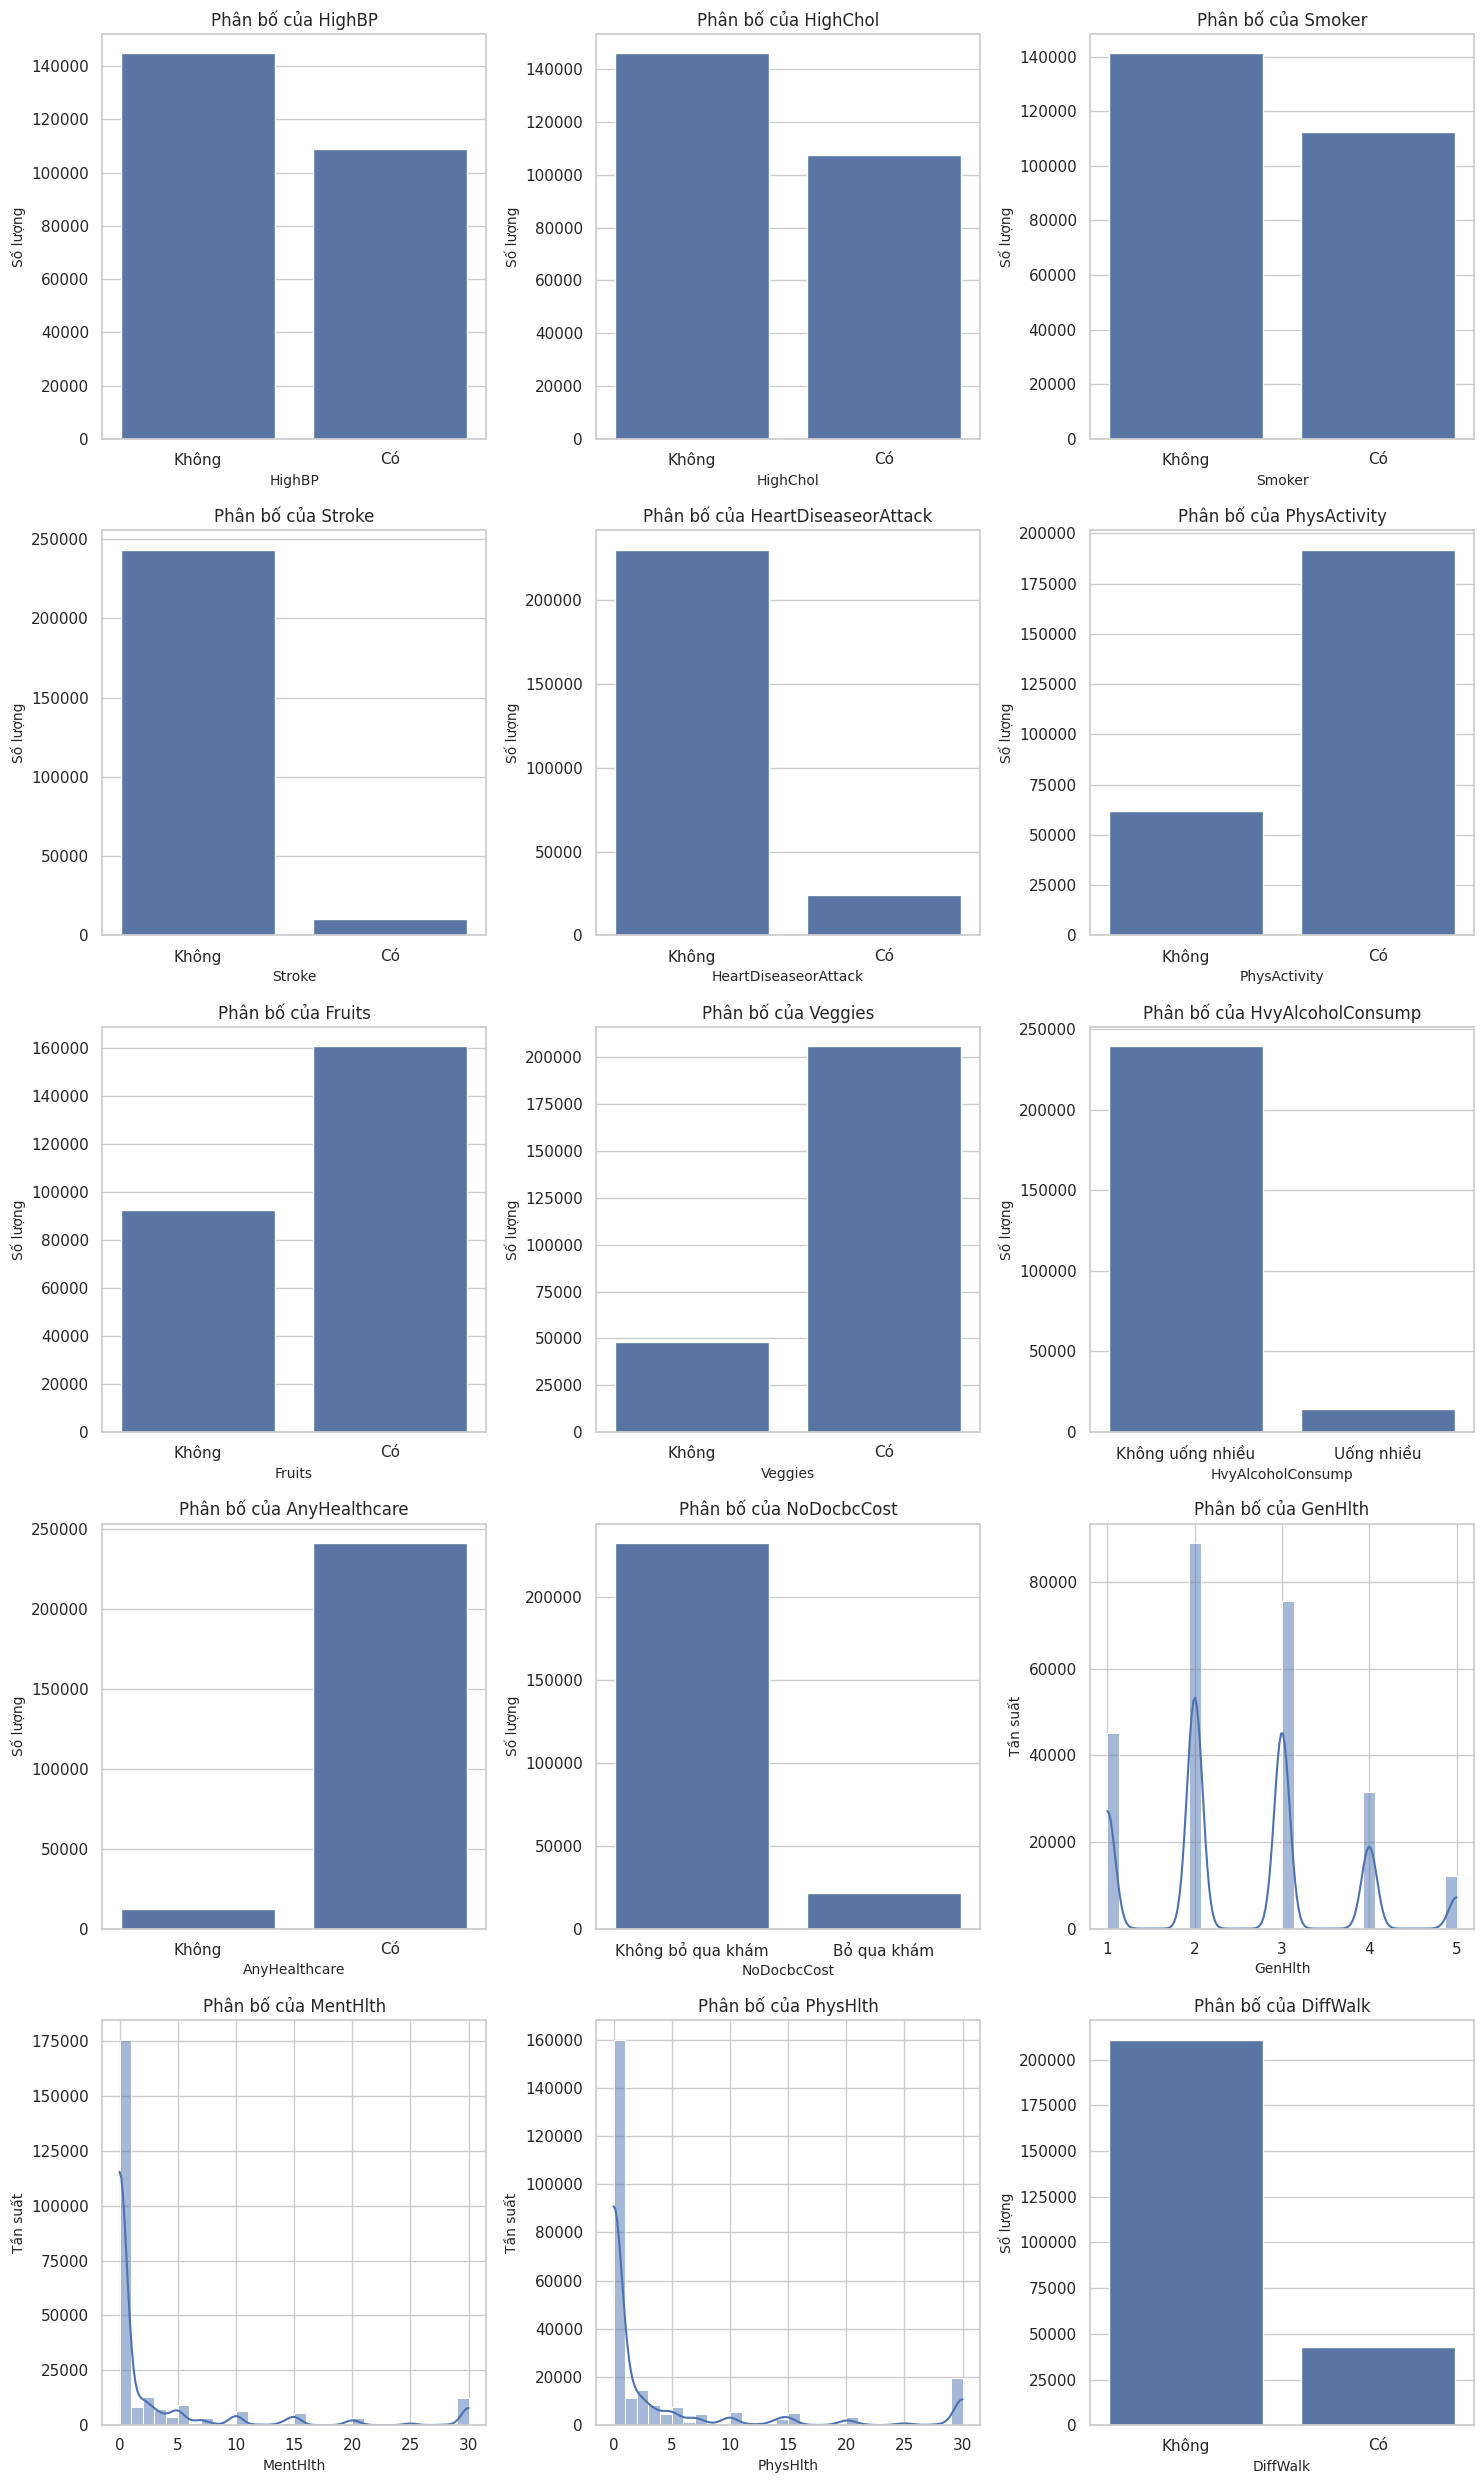

In [13]:
# Visualize the distribution of lifestyle variables

# Define the lifestyle columns to visualize
lifestyle_cols_to_plot = ['HighBP', 'HighChol', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
                          'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump',
                          'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth',
                          'DiffWalk']

# Determine the number of rows and columns for the subplots
n_cols = 3
n_rows = (len(lifestyle_cols_to_plot) + n_cols - 1) // n_cols

plt.figure(figsize=(15, n_rows * 5)) # Adjust figure size based on number of rows

for i, col in enumerate(lifestyle_cols_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)

    if col in ['HighBP', 'HighChol', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
               'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump',
               'AnyHealthcare', 'NoDocbcCost', 'DiffWalk']:
        # Countplot for binary variables
        sns.countplot(x=col, data=df_lifestyle) # Removed palette
        plt.title(f'Phân bố của {col}', fontsize=12)
        plt.xlabel(col, fontsize=10)
        plt.ylabel('Số lượng', fontsize=10)
        # Add meaningful labels for binary variables
        if col in ['HighBP', 'HighChol', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'DiffWalk']:
             plt.xticks([0, 1], ['Không', 'Có'])
        elif col in ['PhysActivity', 'Fruits', 'Veggies', 'AnyHealthcare']:
             plt.xticks([0, 1], ['Không', 'Có'])
        elif col == 'HvyAlcoholConsump':
             plt.xticks([0, 1], ['Không uống nhiều', 'Uống nhiều'])
        elif col == 'NoDocbcCost':
             plt.xticks([0, 1], ['Không bỏ qua khám', 'Bỏ qua khám'])


    elif col in ['GenHlth', 'MentHlth', 'PhysHlth']:
        # Histplot for ordinal/integer variables
        sns.histplot(data=df_lifestyle, x=col, kde=True, bins=30) # Removed palette
        plt.title(f'Phân bố của {col}', fontsize=12)
        plt.xlabel(col, fontsize=10)
        plt.ylabel('Tần suất', fontsize=10)


plt.tight_layout()
plt.show()

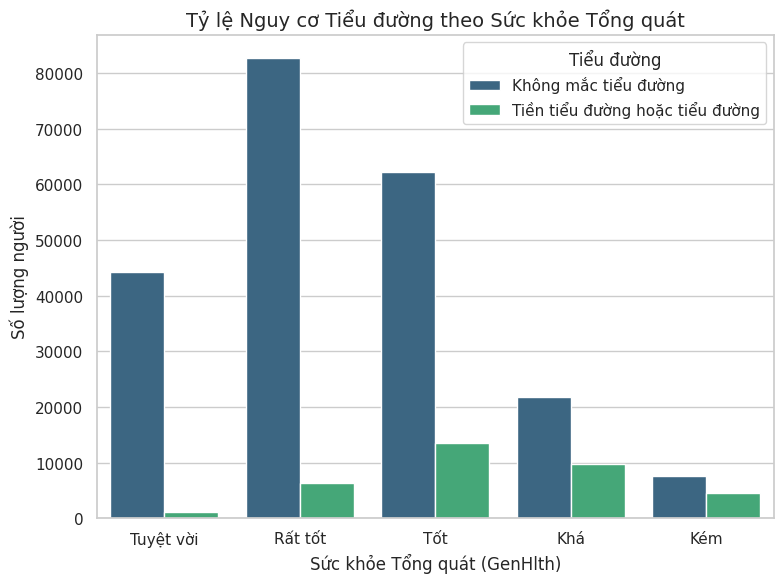

In [14]:
# Analyze the distribution of diabetes based on 'GenHlth' (General Health)
plt.figure(figsize=[8, 6])
sns.countplot(x='GenHlth', hue='Diabetes_binary', data=df_lifestyle, palette='viridis')
plt.xticks([0, 1, 2, 3, 4], ['Tuyệt vời', 'Rất tốt', 'Tốt', 'Khá', 'Kém'], rotation=0)
plt.title('Tỷ lệ Nguy cơ Tiểu đường theo Sức khỏe Tổng quát', fontsize=14)
plt.xlabel('Sức khỏe Tổng quát (GenHlth)', fontsize=12)
plt.ylabel('Số lượng người', fontsize=12)
plt.legend(title='Tiểu đường', labels=['Không mắc tiểu đường', 'Tiền tiểu đường hoặc tiểu đường'])
plt.tight_layout()
plt.show()

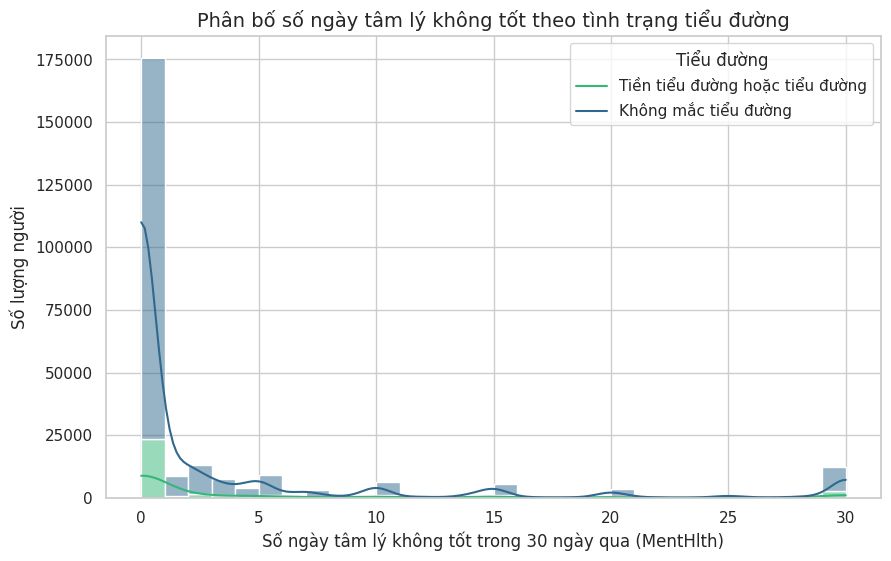

In [15]:
# Analyze the distribution of diabetes based on 'MentHlth' (Mental Health)
plt.figure(figsize=[10, 6])
sns.histplot(data=df_lifestyle, x='MentHlth', hue='Diabetes_binary', multiple='stack', kde=True, bins=30, palette='viridis')
plt.title('Phân bố số ngày tâm lý không tốt theo tình trạng tiểu đường', fontsize=14)
plt.xlabel('Số ngày tâm lý không tốt trong 30 ngày qua (MentHlth)', fontsize=12)
plt.ylabel('Số lượng người', fontsize=12)
plt.legend(title='Tiểu đường', labels=['Tiền tiểu đường hoặc tiểu đường', 'Không mắc tiểu đường'])
plt.show()

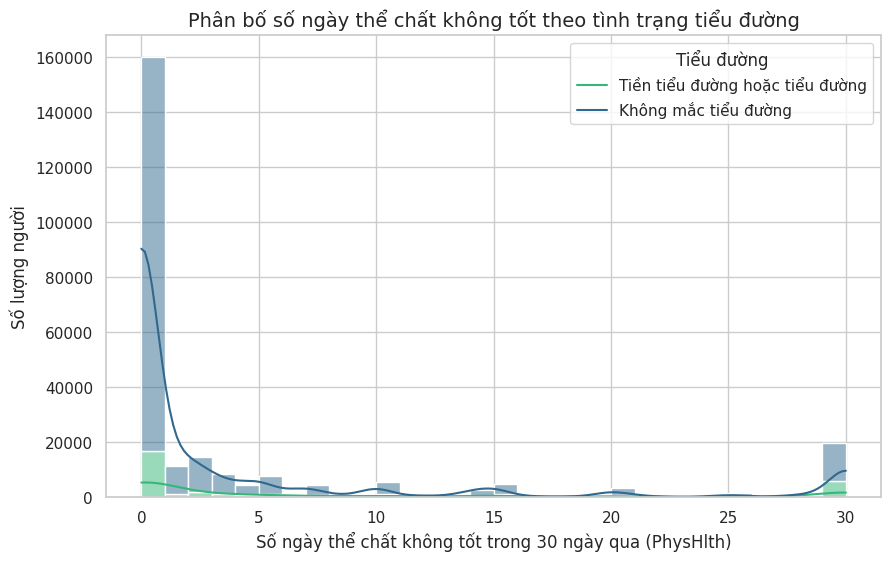

In [16]:
# Analyze the distribution of diabetes based on 'PhysHlth' (Physical Health)
plt.figure(figsize=[10, 6])
sns.histplot(data=df_lifestyle, x='PhysHlth', hue='Diabetes_binary', multiple='stack', kde=True, bins=30, palette='viridis')
plt.title('Phân bố số ngày thể chất không tốt theo tình trạng tiểu đường', fontsize=14)
plt.xlabel('Số ngày thể chất không tốt trong 30 ngày qua (PhysHlth)', fontsize=12)
plt.ylabel('Số lượng người', fontsize=12)
plt.legend(title='Tiểu đường', labels=['Tiền tiểu đường hoặc tiểu đường', 'Không mắc tiểu đường'])
plt.show()

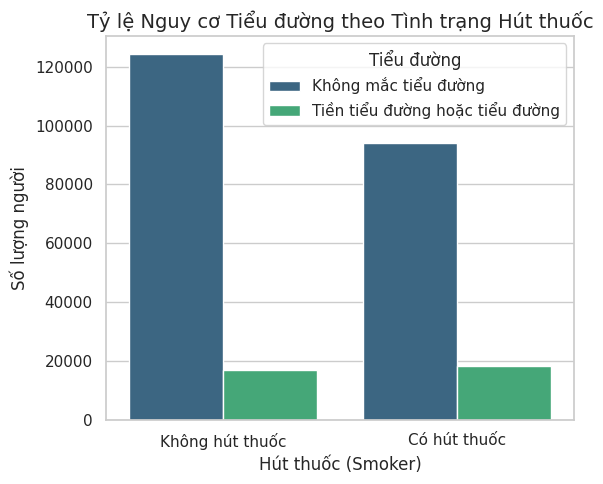


Tỷ lệ mắc bệnh tiểu đường theo tình trạng hút thuốc:
Không hút thuốc (Smoker=0): 12.06%
Có hút thuốc (Smoker=1): 16.29%


In [17]:
# Analyze the distribution of diabetes based on 'Smoker'
plt.figure(figsize=[6, 5])
sns.countplot(x='Smoker', hue='Diabetes_binary', data=df_lifestyle, palette='viridis')
plt.xticks([0, 1], ['Không hút thuốc', 'Có hút thuốc'])
plt.title('Tỷ lệ Nguy cơ Tiểu đường theo Tình trạng Hút thuốc', fontsize=14)
plt.xlabel('Hút thuốc (Smoker)', fontsize=12)
plt.ylabel('Số lượng người', fontsize=12)
plt.legend(title='Tiểu đường', labels=['Không mắc tiểu đường', 'Tiền tiểu đường hoặc tiểu đường'])
plt.tight_layout()
plt.show()

# Calculate and print the percentage of diabetes for smokers and non-smokers
smoker_diabetes_percentage = df_lifestyle.groupby('Smoker')['Diabetes_binary'].mean() * 100
print("\nTỷ lệ mắc bệnh tiểu đường theo tình trạng hút thuốc:")
print(f"Không hút thuốc (Smoker=0): {smoker_diabetes_percentage[0]:.2f}%")
print(f"Có hút thuốc (Smoker=1): {smoker_diabetes_percentage[1]:.2f}%")

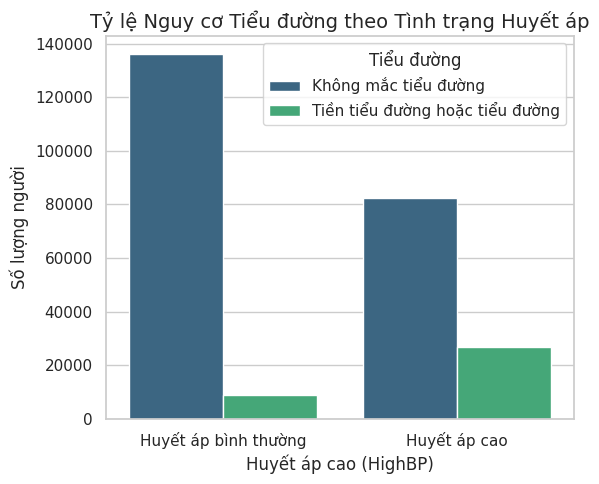


Tỷ lệ mắc bệnh tiểu đường theo tình trạng huyết áp:
Huyết áp bình thường (HighBP=0): 6.04%
Huyết áp cao (HighBP=1): 24.45%


In [18]:
# Analyze the distribution of diabetes based on 'HighBP'
plt.figure(figsize=[6, 5])
sns.countplot(x='HighBP', hue='Diabetes_binary', data=df_lifestyle, palette='viridis')
plt.xticks([0, 1], ['Huyết áp bình thường', 'Huyết áp cao'])
plt.title('Tỷ lệ Nguy cơ Tiểu đường theo Tình trạng Huyết áp', fontsize=14)
plt.xlabel('Huyết áp cao (HighBP)', fontsize=12)
plt.ylabel('Số lượng người', fontsize=12)
plt.legend(title='Tiểu đường', labels=['Không mắc tiểu đường', 'Tiền tiểu đường hoặc tiểu đường'])
plt.tight_layout()
plt.show()

# Calculate and print the percentage of diabetes for HighBP and normal BP
highbp_diabetes_percentage = df_lifestyle.groupby('HighBP')['Diabetes_binary'].mean() * 100
print("\nTỷ lệ mắc bệnh tiểu đường theo tình trạng huyết áp:")
print(f"Huyết áp bình thường (HighBP=0): {highbp_diabetes_percentage[0]:.2f}%")
print(f"Huyết áp cao (HighBP=1): {highbp_diabetes_percentage[1]:.2f}%")

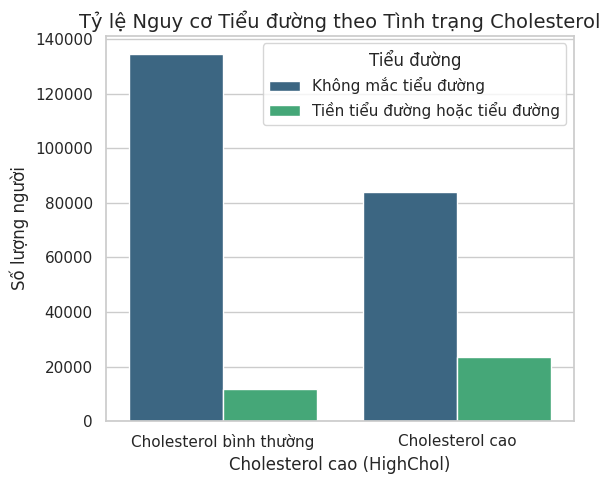


Tỷ lệ mắc bệnh tiểu đường theo tình trạng cholesterol:
Cholesterol bình thường (HighChol=0): 7.98%
Cholesterol cao (HighChol=1): 22.01%


In [19]:
# Analyze the distribution of diabetes based on 'HighChol'
plt.figure(figsize=[6, 5])
sns.countplot(x='HighChol', hue='Diabetes_binary', data=df_lifestyle, palette='viridis')
plt.xticks([0, 1], ['Cholesterol bình thường', 'Cholesterol cao'])
plt.title('Tỷ lệ Nguy cơ Tiểu đường theo Tình trạng Cholesterol', fontsize=14)
plt.xlabel('Cholesterol cao (HighChol)', fontsize=12)
plt.ylabel('Số lượng người', fontsize=12)
plt.legend(title='Tiểu đường', labels=['Không mắc tiểu đường', 'Tiền tiểu đường hoặc tiểu đường'])
plt.tight_layout()
plt.show()

# Calculate and print the percentage of diabetes for HighChol and normal Chol
highchol_diabetes_percentage = df_lifestyle.groupby('HighChol')['Diabetes_binary'].mean() * 100
print("\nTỷ lệ mắc bệnh tiểu đường theo tình trạng cholesterol:")
print(f"Cholesterol bình thường (HighChol=0): {highchol_diabetes_percentage[0]:.2f}%")
print(f"Cholesterol cao (HighChol=1): {highchol_diabetes_percentage[1]:.2f}%")

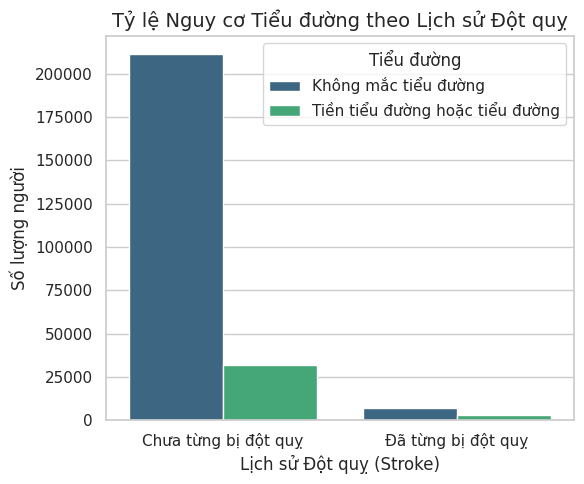


Tỷ lệ mắc bệnh tiểu đường theo lịch sử đột quỵ:
Chưa từng bị đột quỵ (Stroke=0): 13.18%
Đã từng bị đột quỵ (Stroke=1): 31.75%


In [20]:
# Analyze the distribution of diabetes based on 'Stroke'
plt.figure(figsize=[6, 5])
sns.countplot(x='Stroke', hue='Diabetes_binary', data=df_lifestyle, palette='viridis')
plt.xticks([0, 1], ['Chưa từng bị đột quỵ', 'Đã từng bị đột quỵ'])
plt.title('Tỷ lệ Nguy cơ Tiểu đường theo Lịch sử Đột quỵ', fontsize=14)
plt.xlabel('Lịch sử Đột quỵ (Stroke)', fontsize=12)
plt.ylabel('Số lượng người', fontsize=12)
plt.legend(title='Tiểu đường', labels=['Không mắc tiểu đường', 'Tiền tiểu đường hoặc tiểu đường'])
plt.tight_layout()
plt.show()

# Calculate and print the percentage of diabetes for those with and without a history of stroke
stroke_diabetes_percentage = df_lifestyle.groupby('Stroke')['Diabetes_binary'].mean() * 100
print("\nTỷ lệ mắc bệnh tiểu đường theo lịch sử đột quỵ:")
print(f"Chưa từng bị đột quỵ (Stroke=0): {stroke_diabetes_percentage[0]:.2f}%")
print(f"Đã từng bị đột quỵ (Stroke=1): {stroke_diabetes_percentage[1]:.2f}%")

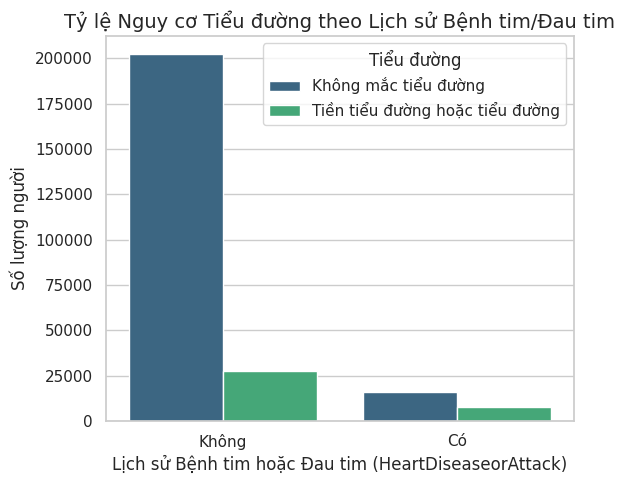


Tỷ lệ mắc bệnh tiểu đường theo lịch sử bệnh tim hoặc đau tim:
Không (HeartDiseaseorAttack=0): 11.95%
Có (HeartDiseaseorAttack=1): 32.97%


In [21]:
# Analyze the distribution of diabetes based on 'HeartDiseaseorAttack'
plt.figure(figsize=[6, 5])
sns.countplot(x='HeartDiseaseorAttack', hue='Diabetes_binary', data=df_lifestyle, palette='viridis')
plt.xticks([0, 1], ['Không', 'Có'])
plt.title('Tỷ lệ Nguy cơ Tiểu đường theo Lịch sử Bệnh tim/Đau tim', fontsize=14)
plt.xlabel('Lịch sử Bệnh tim hoặc Đau tim (HeartDiseaseorAttack)', fontsize=12)
plt.ylabel('Số lượng người', fontsize=12)
plt.legend(title='Tiểu đường', labels=['Không mắc tiểu đường', 'Tiền tiểu đường hoặc tiểu đường'])
plt.tight_layout()
plt.show()

# Calculate and print the percentage of diabetes for those with and without a history of heart disease/attack
heartdisease_diabetes_percentage = df_lifestyle.groupby('HeartDiseaseorAttack')['Diabetes_binary'].mean() * 100
print("\nTỷ lệ mắc bệnh tiểu đường theo lịch sử bệnh tim hoặc đau tim:")
print(f"Không (HeartDiseaseorAttack=0): {heartdisease_diabetes_percentage[0]:.2f}%")
print(f"Có (HeartDiseaseorAttack=1): {heartdisease_diabetes_percentage[1]:.2f}%")

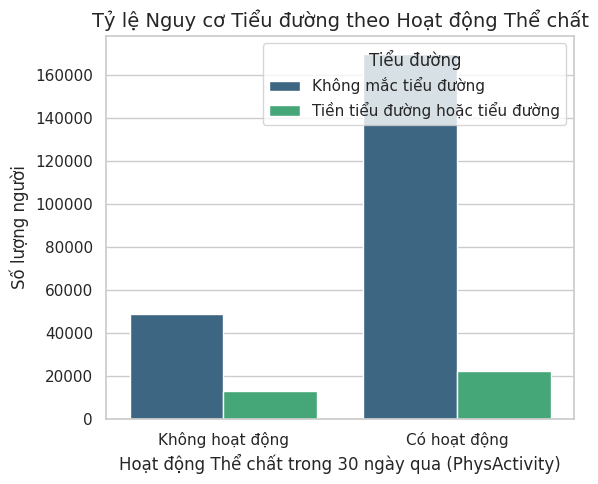


Tỷ lệ mắc bệnh tiểu đường theo hoạt động thể chất:
Không hoạt động (PhysActivity=0): 21.14%
Có hoạt động (PhysActivity=1): 11.61%


In [22]:
# Analyze the distribution of diabetes based on 'PhysActivity'
plt.figure(figsize=[6, 5])
sns.countplot(x='PhysActivity', hue='Diabetes_binary', data=df_lifestyle, palette='viridis')
plt.xticks([0, 1], ['Không hoạt động', 'Có hoạt động'])
plt.title('Tỷ lệ Nguy cơ Tiểu đường theo Hoạt động Thể chất', fontsize=14)
plt.xlabel('Hoạt động Thể chất trong 30 ngày qua (PhysActivity)', fontsize=12)
plt.ylabel('Số lượng người', fontsize=12)
plt.legend(title='Tiểu đường', labels=['Không mắc tiểu đường', 'Tiền tiểu đường hoặc tiểu đường'])
plt.tight_layout()
plt.show()

# Calculate and print the percentage of diabetes for those with and without physical activity
physactivity_diabetes_percentage = df_lifestyle.groupby('PhysActivity')['Diabetes_binary'].mean() * 100
print("\nTỷ lệ mắc bệnh tiểu đường theo hoạt động thể chất:")
print(f"Không hoạt động (PhysActivity=0): {physactivity_diabetes_percentage[0]:.2f}%")
print(f"Có hoạt động (PhysActivity=1): {physactivity_diabetes_percentage[1]:.2f}%")

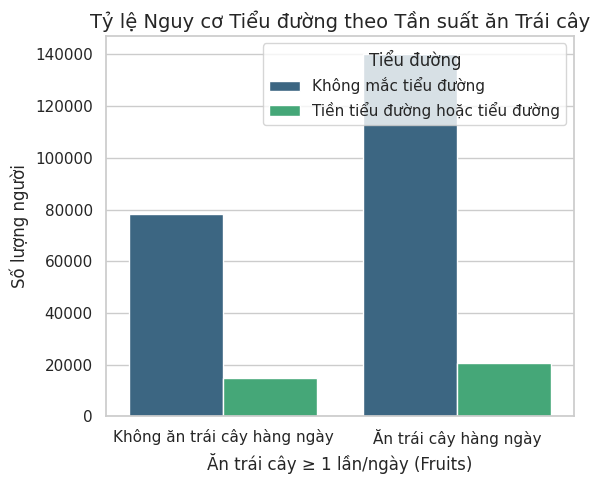


Tỷ lệ mắc bệnh tiểu đường theo tần suất ăn trái cây:
Không ăn trái cây hàng ngày (Fruits=0): 15.79%
Ăn trái cây hàng ngày (Fruits=1): 12.86%


In [23]:
# Analyze the distribution of diabetes based on 'Fruits'
plt.figure(figsize=[6, 5])
sns.countplot(x='Fruits', hue='Diabetes_binary', data=df_lifestyle, palette='viridis')
plt.xticks([0, 1], ['Không ăn trái cây hàng ngày', 'Ăn trái cây hàng ngày'])
plt.title('Tỷ lệ Nguy cơ Tiểu đường theo Tần suất ăn Trái cây', fontsize=14)
plt.xlabel('Ăn trái cây ≥ 1 lần/ngày (Fruits)', fontsize=12)
plt.ylabel('Số lượng người', fontsize=12)
plt.legend(title='Tiểu đường', labels=['Không mắc tiểu đường', 'Tiền tiểu đường hoặc tiểu đường'])
plt.tight_layout()
plt.show()

# Calculate and print the percentage of diabetes for those who eat fruits daily and those who don't
fruits_diabetes_percentage = df_lifestyle.groupby('Fruits')['Diabetes_binary'].mean() * 100
print("\nTỷ lệ mắc bệnh tiểu đường theo tần suất ăn trái cây:")
print(f"Không ăn trái cây hàng ngày (Fruits=0): {fruits_diabetes_percentage[0]:.2f}%")
print(f"Ăn trái cây hàng ngày (Fruits=1): {fruits_diabetes_percentage[1]:.2f}%")

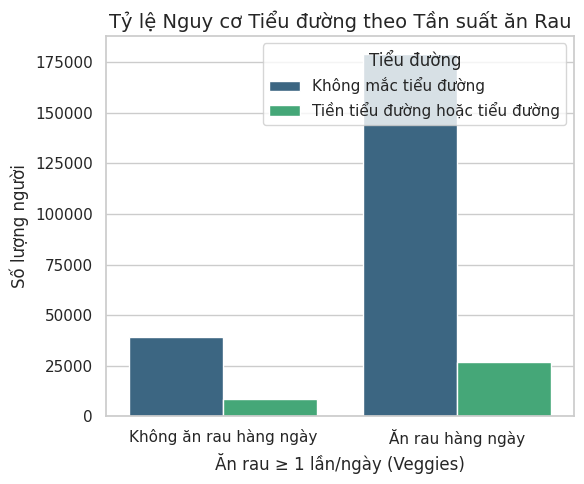


Tỷ lệ mắc bệnh tiểu đường theo tần suất ăn rau:
Không ăn rau hàng ngày (Veggies=0): 18.00%
Ăn rau hàng ngày (Veggies=1): 12.99%


In [24]:
# Analyze the distribution of diabetes based on 'Veggies'
plt.figure(figsize=[6, 5])
sns.countplot(x='Veggies', hue='Diabetes_binary', data=df_lifestyle, palette='viridis')
plt.xticks([0, 1], ['Không ăn rau hàng ngày', 'Ăn rau hàng ngày'])
plt.title('Tỷ lệ Nguy cơ Tiểu đường theo Tần suất ăn Rau', fontsize=14)
plt.xlabel('Ăn rau ≥ 1 lần/ngày (Veggies)', fontsize=12)
plt.ylabel('Số lượng người', fontsize=12)
plt.legend(title='Tiểu đường', labels=['Không mắc tiểu đường', 'Tiền tiểu đường hoặc tiểu đường'])
plt.tight_layout()
plt.show()

# Calculate and print the percentage of diabetes for those who eat veggies daily and those who don't
veggies_diabetes_percentage = df_lifestyle.groupby('Veggies')['Diabetes_binary'].mean() * 100
print("\nTỷ lệ mắc bệnh tiểu đường theo tần suất ăn rau:")
print(f"Không ăn rau hàng ngày (Veggies=0): {veggies_diabetes_percentage[0]:.2f}%")
print(f"Ăn rau hàng ngày (Veggies=1): {veggies_diabetes_percentage[1]:.2f}%")

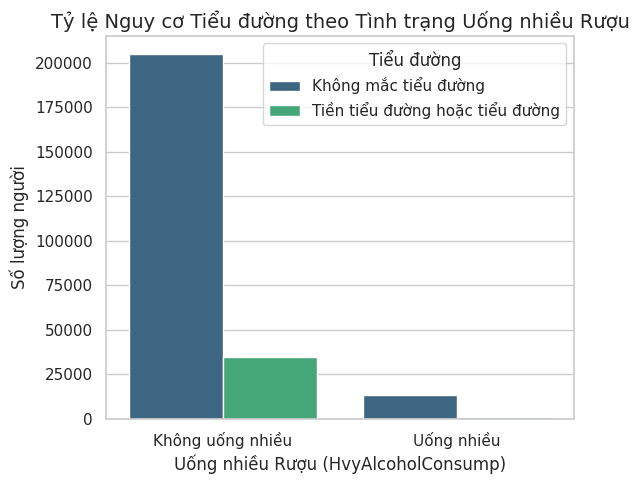


Tỷ lệ mắc bệnh tiểu đường theo tình trạng uống nhiều rượu:
Không uống nhiều (HvyAlcoholConsump=0): 14.42%
Uống nhiều (HvyAlcoholConsump=1): 5.84%


In [25]:
# Analyze the distribution of diabetes based on 'HvyAlcoholConsump'
plt.figure(figsize=[6, 5])
sns.countplot(x='HvyAlcoholConsump', hue='Diabetes_binary', data=df_lifestyle, palette='viridis')
plt.xticks([0, 1], ['Không uống nhiều', 'Uống nhiều'])
plt.title('Tỷ lệ Nguy cơ Tiểu đường theo Tình trạng Uống nhiều Rượu', fontsize=14)
plt.xlabel('Uống nhiều Rượu (HvyAlcoholConsump)', fontsize=12)
plt.ylabel('Số lượng người', fontsize=12)
plt.legend(title='Tiểu đường', labels=['Không mắc tiểu đường', 'Tiền tiểu đường hoặc tiểu đường'])
plt.tight_layout()
plt.show()

# Calculate and print the percentage of diabetes for those with and without heavy alcohol consumption
alcohol_diabetes_percentage = df_lifestyle.groupby('HvyAlcoholConsump')['Diabetes_binary'].mean() * 100
print("\nTỷ lệ mắc bệnh tiểu đường theo tình trạng uống nhiều rượu:")
print(f"Không uống nhiều (HvyAlcoholConsump=0): {alcohol_diabetes_percentage[0]:.2f}%")
print(f"Uống nhiều (HvyAlcoholConsump=1): {alcohol_diabetes_percentage[1]:.2f}%")

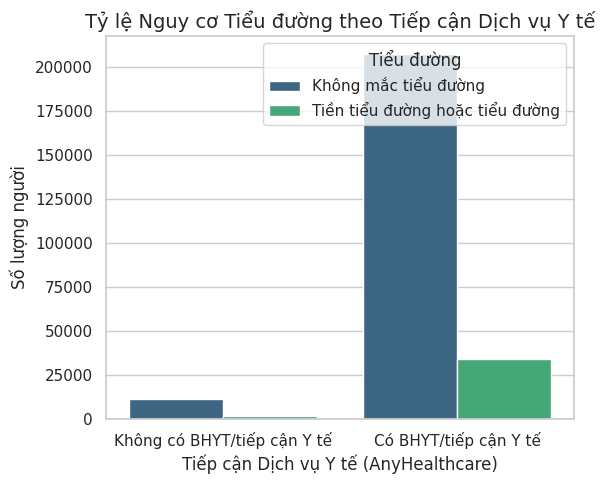


Tỷ lệ mắc bệnh tiểu đường theo tiếp cận dịch vụ y tế:
Không có BHYT/tiếp cận Y tế (AnyHealthcare=0): 11.45%
Có BHYT/tiếp cận Y tế (AnyHealthcare=1): 14.06%


In [26]:
# Analyze the distribution of diabetes based on 'AnyHealthcare'
plt.figure(figsize=[6, 5])
sns.countplot(x='AnyHealthcare', hue='Diabetes_binary', data=df_lifestyle, palette='viridis')
plt.xticks([0, 1], ['Không có BHYT/tiếp cận Y tế', 'Có BHYT/tiếp cận Y tế'])
plt.title('Tỷ lệ Nguy cơ Tiểu đường theo Tiếp cận Dịch vụ Y tế', fontsize=14)
plt.xlabel('Tiếp cận Dịch vụ Y tế (AnyHealthcare)', fontsize=12)
plt.ylabel('Số lượng người', fontsize=12)
plt.legend(title='Tiểu đường', labels=['Không mắc tiểu đường', 'Tiền tiểu đường hoặc tiểu đường'])
plt.tight_layout()
plt.show()

# Calculate and print the percentage of diabetes for those with and without healthcare access
healthcare_diabetes_percentage = df_lifestyle.groupby('AnyHealthcare')['Diabetes_binary'].mean() * 100
print("\nTỷ lệ mắc bệnh tiểu đường theo tiếp cận dịch vụ y tế:")
print(f"Không có BHYT/tiếp cận Y tế (AnyHealthcare=0): {healthcare_diabetes_percentage[0]:.2f}%")
print(f"Có BHYT/tiếp cận Y tế (AnyHealthcare=1): {healthcare_diabetes_percentage[1]:.2f}%")


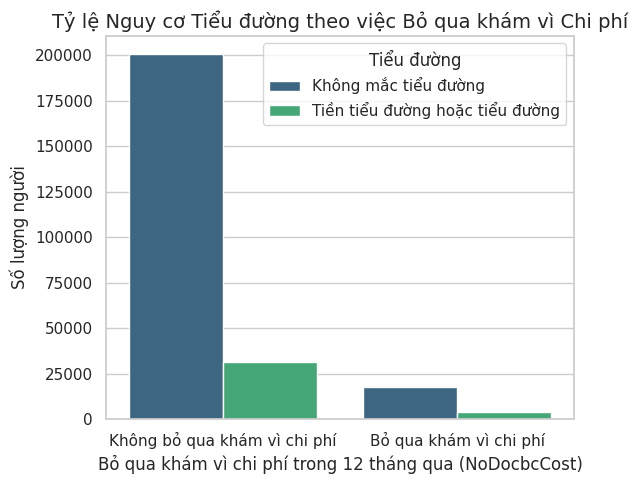


Tỷ lệ mắc bệnh tiểu đường theo việc bỏ qua khám vì chi phí:
Không bỏ qua khám vì chi phí (NoDocbcCost=0): 13.60%
Bỏ qua khám vì chi phí (NoDocbcCost=1): 17.52%


In [27]:
# Analyze the distribution of diabetes based on 'NoDocbcCost'
plt.figure(figsize=[6, 5])
sns.countplot(x='NoDocbcCost', hue='Diabetes_binary', data=df_lifestyle, palette='viridis')
plt.xticks([0, 1], ['Không bỏ qua khám vì chi phí', 'Bỏ qua khám vì chi phí'])
plt.title('Tỷ lệ Nguy cơ Tiểu đường theo việc Bỏ qua khám vì Chi phí', fontsize=14)
plt.xlabel('Bỏ qua khám vì chi phí trong 12 tháng qua (NoDocbcCost)', fontsize=12)
plt.ylabel('Số lượng người', fontsize=12)
plt.legend(title='Tiểu đường', labels=['Không mắc tiểu đường', 'Tiền tiểu đường hoặc tiểu đường'])
plt.tight_layout()
plt.show()

# Calculate and print the percentage of diabetes for those who skipped a doctor visit due to cost
nodocbccost_diabetes_percentage = df_lifestyle.groupby('NoDocbcCost')['Diabetes_binary'].mean() * 100
print("\nTỷ lệ mắc bệnh tiểu đường theo việc bỏ qua khám vì chi phí:")
print(f"Không bỏ qua khám vì chi phí (NoDocbcCost=0): {nodocbccost_diabetes_percentage[0]:.2f}%")
print(f"Bỏ qua khám vì chi phí (NoDocbcCost=1): {nodocbccost_diabetes_percentage[1]:.2f}%")

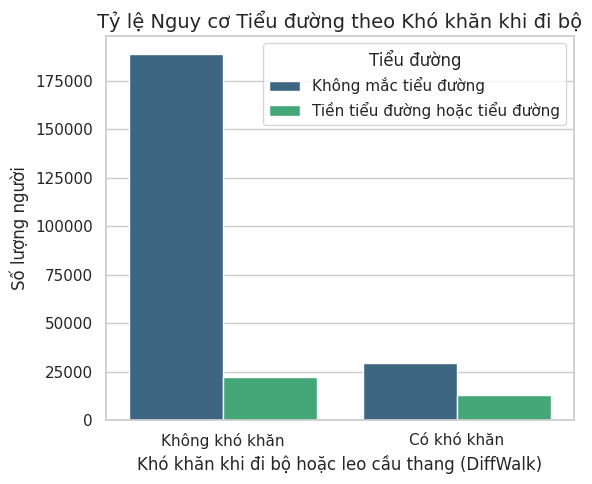


Tỷ lệ mắc bệnh tiểu đường theo khó khăn khi đi bộ:
Không khó khăn (DiffWalk=0): 10.53%
Có khó khăn (DiffWalk=1): 30.75%


In [28]:
# Analyze the distribution of diabetes based on 'DiffWalk'
plt.figure(figsize=[6, 5])
sns.countplot(x='DiffWalk', hue='Diabetes_binary', data=df_lifestyle, palette='viridis')
plt.xticks([0, 1], ['Không khó khăn', 'Có khó khăn'])
plt.title('Tỷ lệ Nguy cơ Tiểu đường theo Khó khăn khi đi bộ', fontsize=14)
plt.xlabel('Khó khăn khi đi bộ hoặc leo cầu thang (DiffWalk)', fontsize=12)
plt.ylabel('Số lượng người', fontsize=12)
plt.legend(title='Tiểu đường', labels=['Không mắc tiểu đường', 'Tiền tiểu đường hoặc tiểu đường'])
plt.tight_layout()
plt.show()

# Calculate and print the percentage of diabetes for those with and without difficulty walking
diffwalk_diabetes_percentage = df_lifestyle.groupby('DiffWalk')['Diabetes_binary'].mean() * 100
print("\nTỷ lệ mắc bệnh tiểu đường theo khó khăn khi đi bộ:")
print(f"Không khó khăn (DiffWalk=0): {diffwalk_diabetes_percentage[0]:.2f}%")
print(f"Có khó khăn (DiffWalk=1): {diffwalk_diabetes_percentage[1]:.2f}%")

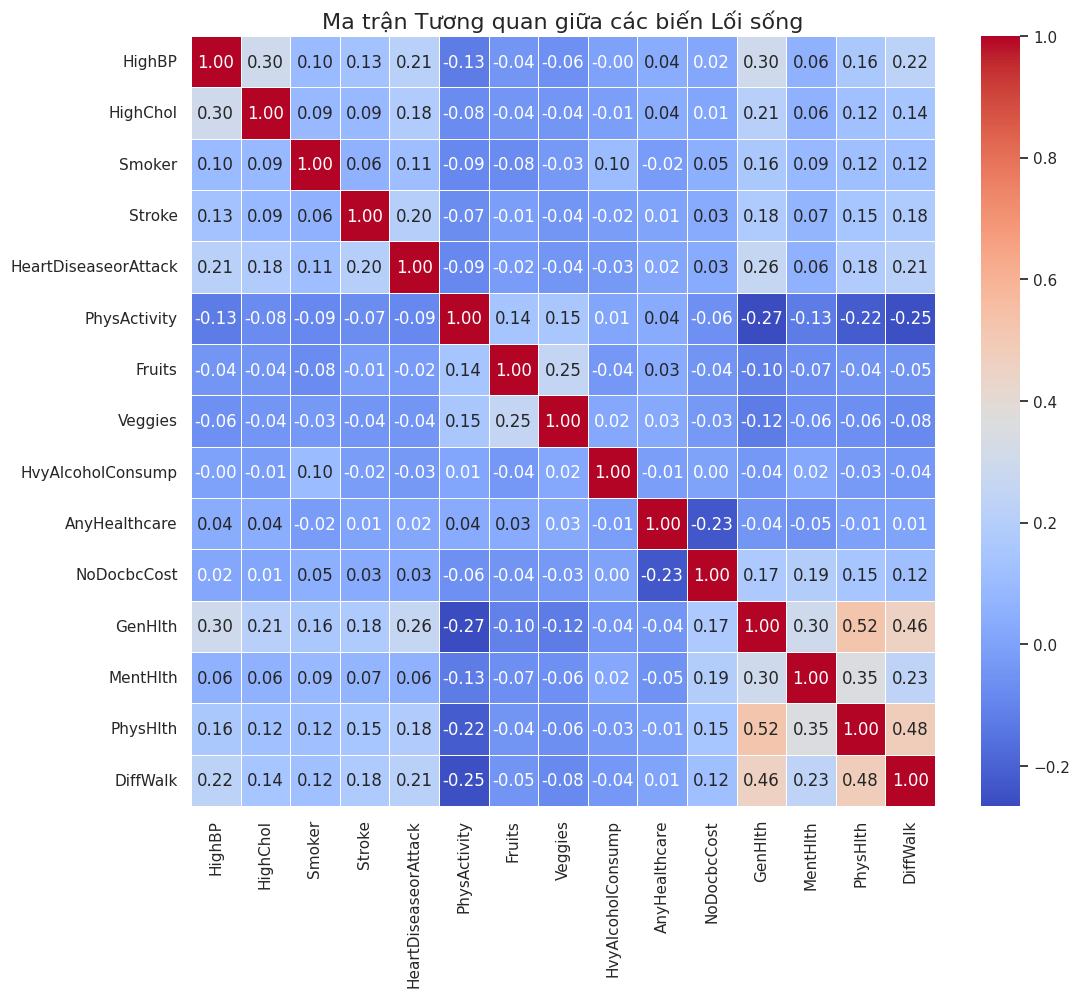


Tương quan giữa các biến Lối sống và Tình trạng Tiểu đường:
Diabetes_binary         1.000000
GenHlth                 0.293569
HighBP                  0.263129
DiffWalk                0.218344
HighChol                0.200276
HeartDiseaseorAttack    0.177282
PhysHlth                0.171337
Stroke                  0.105816
MentHlth                0.069315
Smoker                  0.060789
NoDocbcCost             0.031433
AnyHealthcare           0.016255
Fruits                 -0.040779
Veggies                -0.056584
HvyAlcoholConsump      -0.057056
PhysActivity           -0.118133
Name: Diabetes_binary, dtype: float64


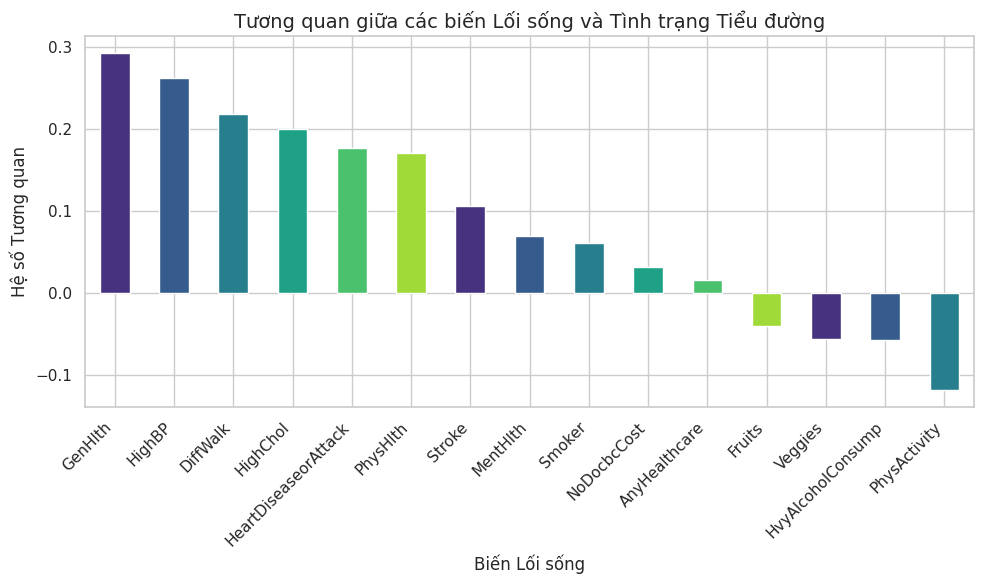

In [29]:
# Prepare data for correlation analysis
# Select lifestyle variables (excluding the target)
lifestyle_features = df_lifestyle.drop('Diabetes_binary', axis=1)

# Calculate the correlation matrix
correlation_matrix = lifestyle_features.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Ma trận Tương quan giữa các biến Lối sống', fontsize=16)
plt.show()

# Calculate the correlation between lifestyle variables and the target variable
# Use the original df with all features
lifestyle_cols_and_target = lifestyle_cols
correlation_with_diabetes = df[lifestyle_cols_and_target].corr()['Diabetes_binary'].sort_values(ascending=False)

print("\nTương quan giữa các biến Lối sống và Tình trạng Tiểu đường:")
print(correlation_with_diabetes)

# Plot the correlation with diabetes
plt.figure(figsize=(10, 6))
correlation_with_diabetes.drop('Diabetes_binary').plot(kind='bar', color=sns.color_palette('viridis'))
plt.title('Tương quan giữa các biến Lối sống và Tình trạng Tiểu đường', fontsize=14)
plt.xlabel('Biến Lối sống', fontsize=12)
plt.ylabel('Hệ số Tương quan', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/tmp/ipython-input-30-155648823.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Tỷ lệ mắc tiểu đường (%)', y='Factor', data=percentage_df, palette='viridis')


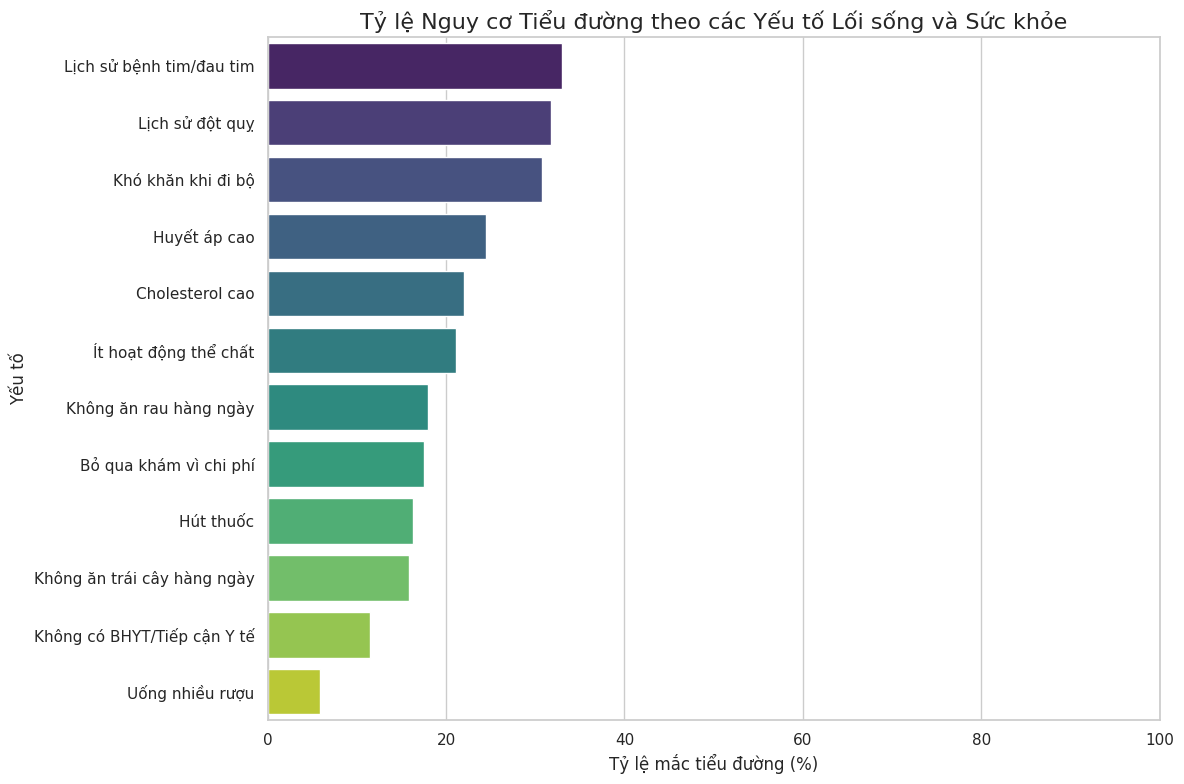

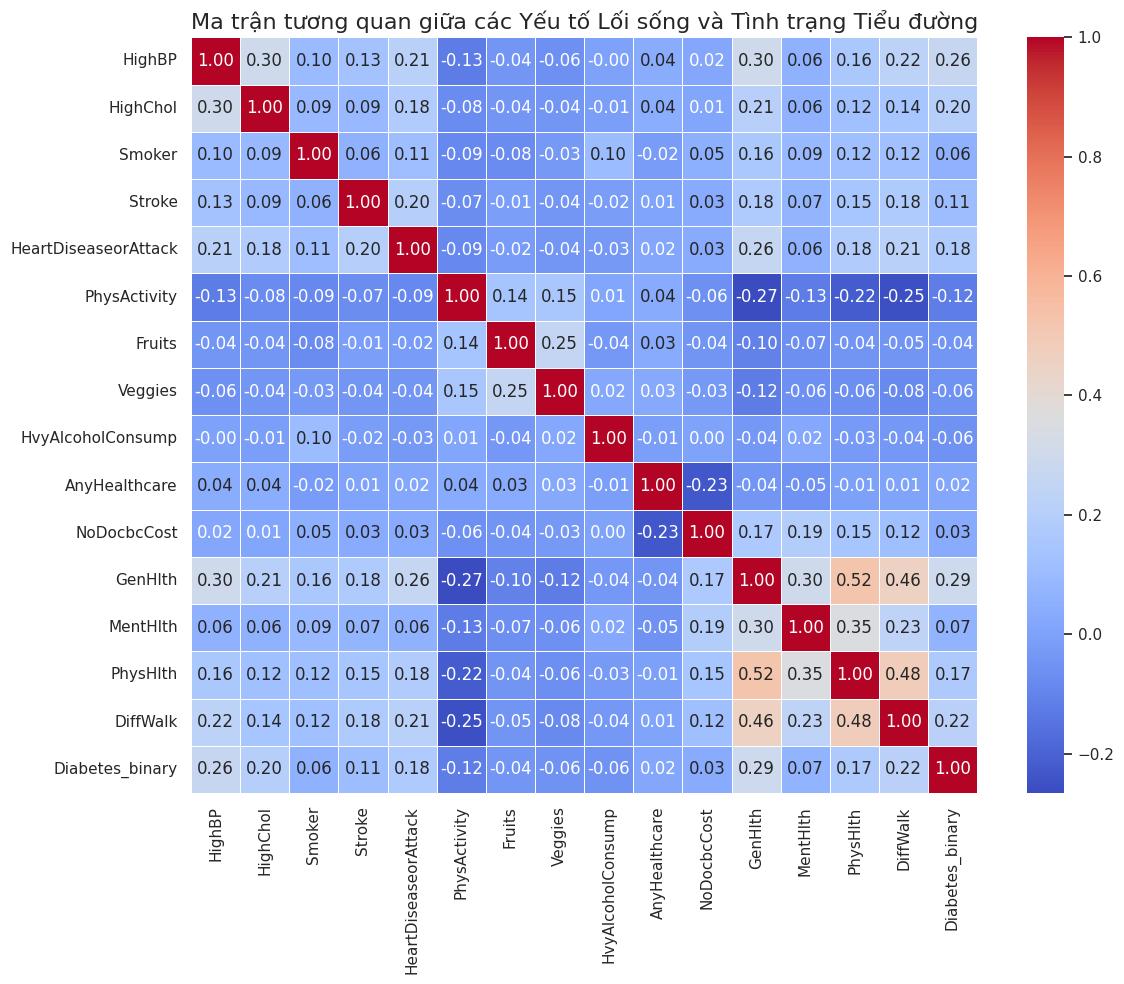

In [30]:
# Combine the percentage dataframes for easier plotting
percentage_df = pd.DataFrame({
    'Factor': ['Hút thuốc', 'Huyết áp cao', 'Cholesterol cao', 'Lịch sử đột quỵ',
               'Lịch sử bệnh tim/đau tim', 'Ít hoạt động thể chất', 'Không ăn trái cây hàng ngày',
               'Không ăn rau hàng ngày', 'Uống nhiều rượu', 'Không có BHYT/Tiếp cận Y tế',
               'Bỏ qua khám vì chi phí', 'Khó khăn khi đi bộ'],
    'Tỷ lệ mắc tiểu đường (%)': [
        smoker_diabetes_percentage[1], highbp_diabetes_percentage[1], highchol_diabetes_percentage[1],
        stroke_diabetes_percentage[1], heartdisease_diabetes_percentage[1], physactivity_diabetes_percentage[0],
        fruits_diabetes_percentage[0], veggies_diabetes_percentage[0], alcohol_diabetes_percentage[1],
        healthcare_diabetes_percentage[0], nodocbccost_diabetes_percentage[1], diffwalk_diabetes_percentage[1]
    ]
})

# Sort the dataframe by diabetes percentage for better visualization
percentage_df = percentage_df.sort_values(by='Tỷ lệ mắc tiểu đường (%)', ascending=False)

# Create a bar plot for the risk factors
plt.figure(figsize=(12, 8))
sns.barplot(x='Tỷ lệ mắc tiểu đường (%)', y='Factor', data=percentage_df, palette='viridis')
plt.title('Tỷ lệ Nguy cơ Tiểu đường theo các Yếu tố Lối sống và Sức khỏe', fontsize=16)
plt.xlabel('Tỷ lệ mắc tiểu đường (%)', fontsize=12)
plt.ylabel('Yếu tố', fontsize=12)
plt.xlim(0, 100) # Set x-axis limit to 0-100
plt.tight_layout()
plt.show()

# Create a heatmap to visualize the correlation between lifestyle factors and diabetes
plt.figure(figsize=(12, 10))
# Include relevant binary/ordinal lifestyle features and the target
correlation_cols = ['HighBP', 'HighChol', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
                    'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump',
                    'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth',
                    'DiffWalk', 'Diabetes_binary']
correlation_matrix = df_lifestyle[correlation_cols].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Ma trận tương quan giữa các Yếu tố Lối sống và Tình trạng Tiểu đường', fontsize=16)
plt.tight_layout()
plt.show()



So sánh Tỷ lệ Nguy cơ Tiểu đường giữa các Nhóm của Yếu tố Lối sống (Binary):
                         Factor  Tỷ lệ mắc tiểu đường (%) (Factor=1 hoặc 0)  \
4      Lịch sử bệnh tim/đau tim                                       32.97   
11           Khó khăn khi đi bộ                                       30.75   
3               Lịch sử đột quỵ                                       31.75   
0                  Huyết áp cao                                       24.45   
1               Cholesterol cao                                       22.01   
5         Ít hoạt động thể chất                                       21.14   
7        Không ăn rau hàng ngày                                       18.00   
2                     Hút thuốc                                       16.29   
9   Không có BHYT/Tiếp cận Y tế                                       17.52   
6   Không ăn trái cây hàng ngày                                       15.79   
10       Bỏ qua khám vì chi phí                      

/tmp/ipython-input-31-1896781820.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Chênh lệch nguy cơ (%)', y='Factor', data=binary_lifestyle_risk_df, palette='coolwarm')


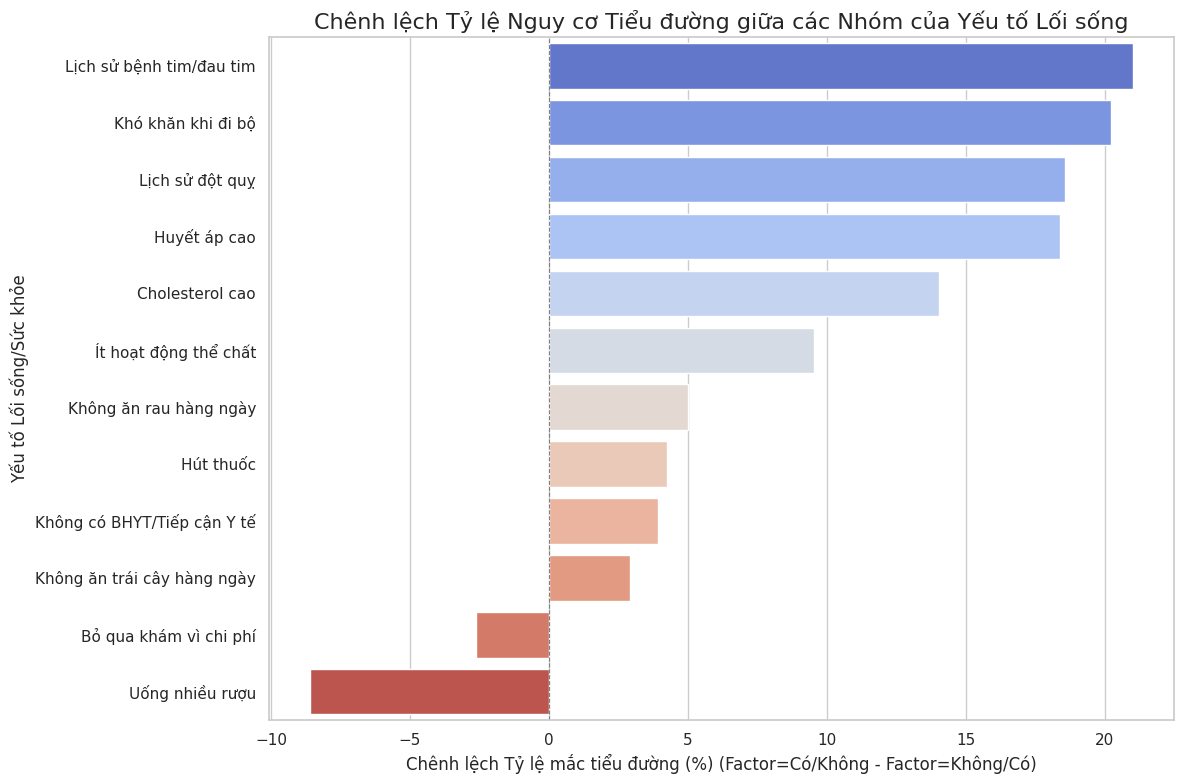

/tmp/ipython-input-31-1896781820.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=var, y='Diabetes_binary', data=df_lifestyle, orient='h', palette='viridis')



Tỷ lệ mắc bệnh tiểu đường theo Sức khỏe Tổng quát (GenHlth):
GenHlth
1     2.52
2     7.16
3    17.79
4    31.01
5    37.89
Name: Diabetes_binary, dtype: float64


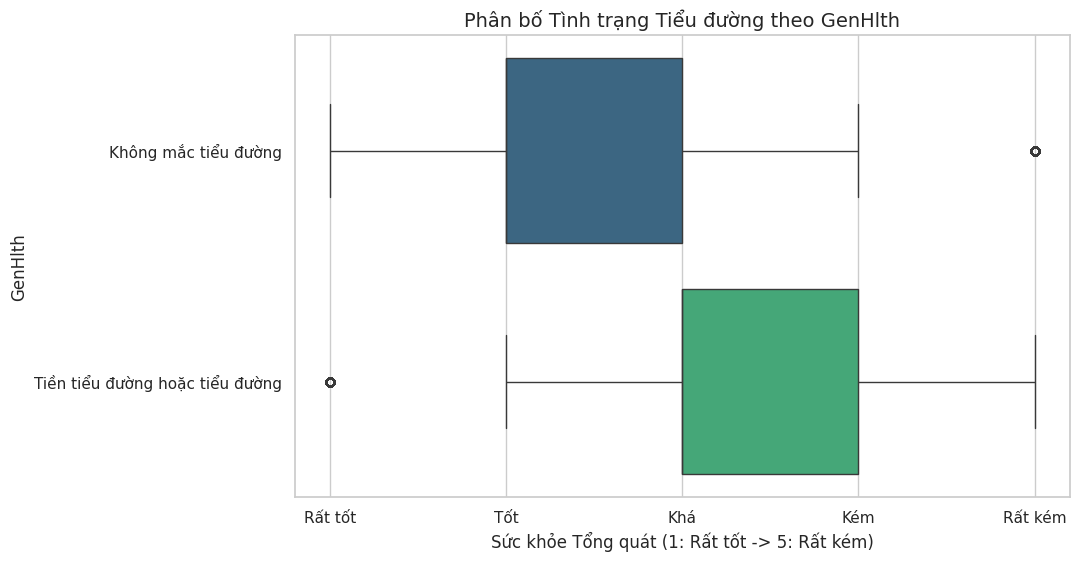

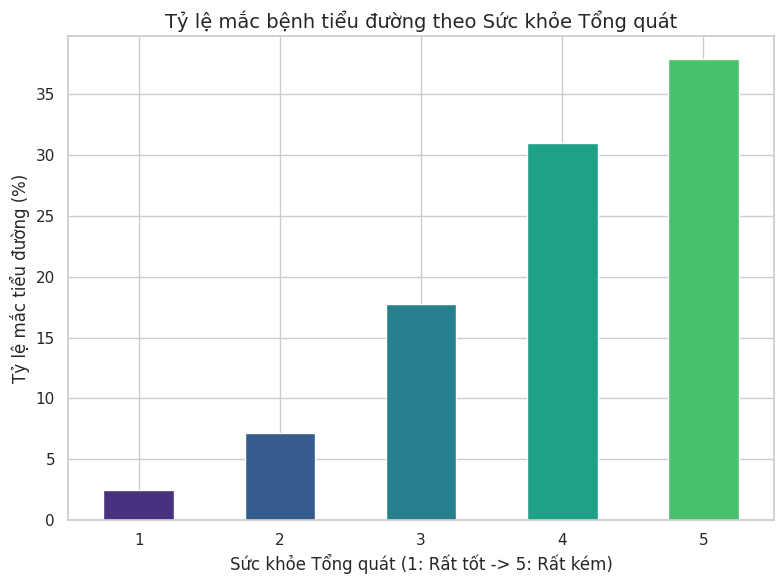

<Figure size 640x480 with 0 Axes>

/tmp/ipython-input-31-1896781820.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=var, y='Diabetes_binary', data=df_lifestyle, orient='h', palette='viridis')
/tmp/ipython-input-31-1896781820.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  menthlth_diabetes_percentage = df_lifestyle.groupby(pd.cut(df_lifestyle['MentHlth'], bins=[-1, 0, 5, 15, 30], labels=['0 ngày', '1-5 ngày', '6-15 ngày', '>15 ngày']))['Diabetes_binary'].mean() * 100



Tỷ lệ mắc bệnh tiểu đường theo Số ngày tâm lý không tốt (MentHlth):
MentHlth
0 ngày       13.32
1-5 ngày     11.86
6-15 ngày    16.65
>15 ngày     22.01
Name: Diabetes_binary, dtype: float64


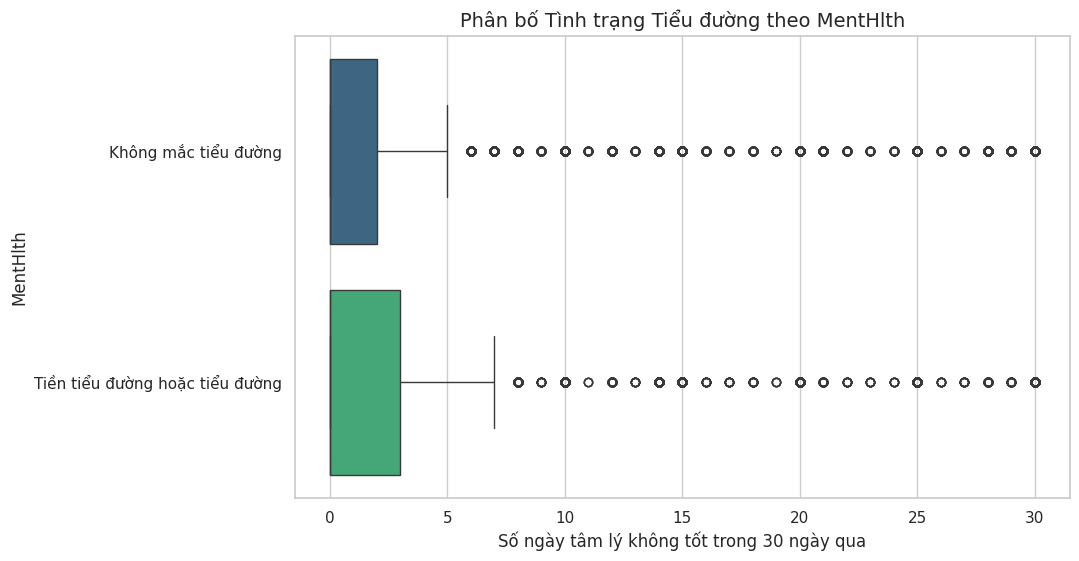

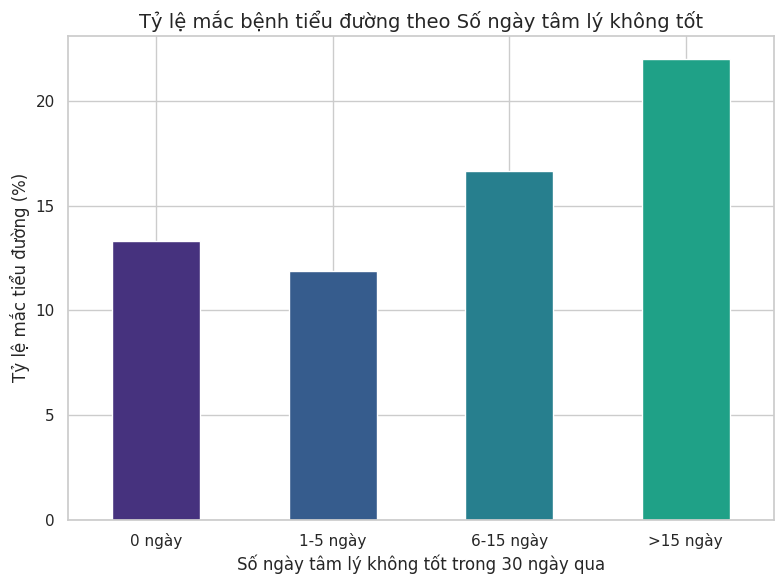

<Figure size 640x480 with 0 Axes>

/tmp/ipython-input-31-1896781820.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=var, y='Diabetes_binary', data=df_lifestyle, orient='h', palette='viridis')



Tỷ lệ mắc bệnh tiểu đường theo Số ngày thể chất không tốt (PhysHlth):
PhysHlth
0 ngày       10.46
1-5 ngày     14.06
6-15 ngày    21.47
>15 ngày     29.01
Name: Diabetes_binary, dtype: float64


/tmp/ipython-input-31-1896781820.py:108: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  physhlth_diabetes_percentage = df_lifestyle.groupby(pd.cut(df_lifestyle['PhysHlth'], bins=[-1, 0, 5, 15, 30], labels=['0 ngày', '1-5 ngày', '6-15 ngày', '>15 ngày']))['Diabetes_binary'].mean() * 100


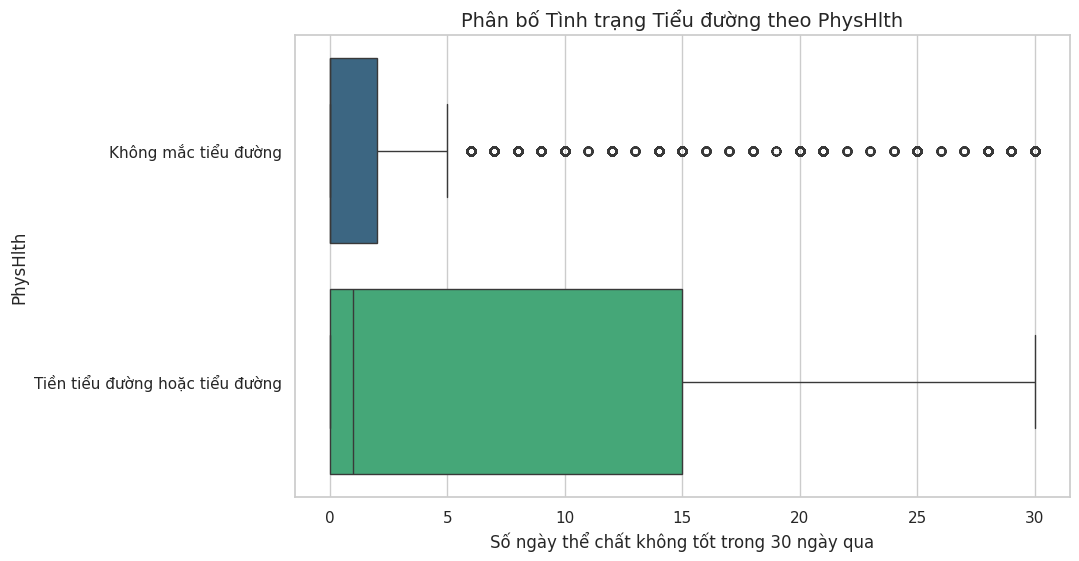

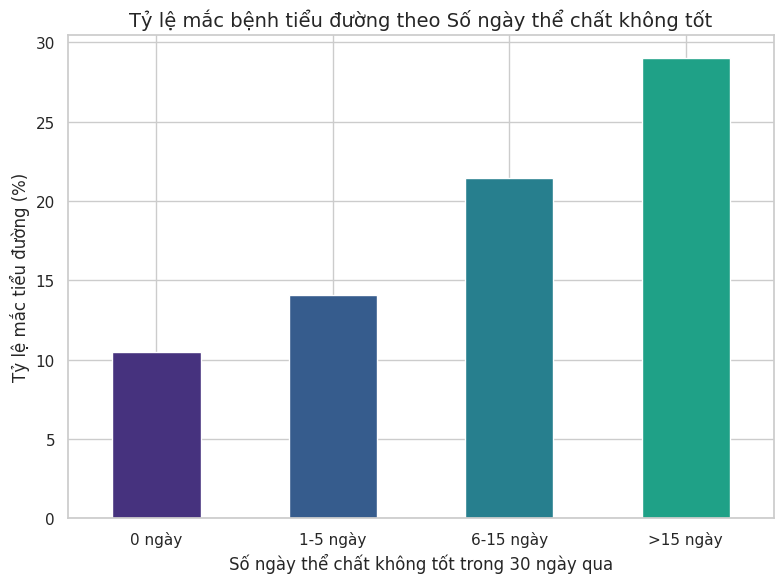

<Figure size 640x480 with 0 Axes>

In [31]:
# prompt: so sánh nguy cơ tiểu đường của các yếu tố lối sống

import pandas as pd
import matplotlib.pyplot as plt
# Create a dataframe for binary lifestyle factors and their diabetes percentage
binary_lifestyle_risk_df = pd.DataFrame({
    'Factor': ['Huyết áp cao', 'Cholesterol cao', 'Hút thuốc', 'Lịch sử đột quỵ',
               'Lịch sử bệnh tim/đau tim', 'Ít hoạt động thể chất', 'Không ăn trái cây hàng ngày',
               'Không ăn rau hàng ngày', 'Uống nhiều rượu', 'Không có BHYT/Tiếp cận Y tế',
               'Bỏ qua khám vì chi phí', 'Khó khăn khi đi bộ'],
    'Tỷ lệ mắc tiểu đường (%) (Factor=1 hoặc 0)': [
        highbp_diabetes_percentage[1], highchol_diabetes_percentage[1], smoker_diabetes_percentage[1],
        stroke_diabetes_percentage[1], heartdisease_diabetes_percentage[1], physactivity_diabetes_percentage[0], # Note: Using 0 for lack of activity
        fruits_diabetes_percentage[0], # Note: Using 0 for not eating daily
        veggies_diabetes_percentage[0], # Note: Using 0 for not eating daily
        alcohol_diabetes_percentage[1], nodocbccost_diabetes_percentage[1],
        healthcare_diabetes_percentage[0], # Note: Using 0 for no healthcare access
        diffwalk_diabetes_percentage[1]
    ],
     'Tỷ lệ mắc tiểu đường (%) (Factor=0 hoặc 1)': [
        highbp_diabetes_percentage[0], highchol_diabetes_percentage[0], smoker_diabetes_percentage[0],
        stroke_diabetes_percentage[0], heartdisease_diabetes_percentage[0], physactivity_diabetes_percentage[1], # Note: Using 1 for activity
        fruits_diabetes_percentage[1], # Note: Using 1 for eating daily
        veggies_diabetes_percentage[1], # Note: Using 1 for eating daily
        alcohol_diabetes_percentage[0], nodocbccost_diabetes_percentage[0],
        healthcare_diabetes_percentage[1], # Note: Using 1 for healthcare access
        diffwalk_diabetes_percentage[0]
    ],
    'Chênh lệch nguy cơ (%)': [
        highbp_diabetes_percentage[1] - highbp_diabetes_percentage[0],
        highchol_diabetes_percentage[1] - highchol_diabetes_percentage[0],
        smoker_diabetes_percentage[1] - smoker_diabetes_percentage[0],
        stroke_diabetes_percentage[1] - stroke_diabetes_percentage[0],
        heartdisease_diabetes_percentage[1] - heartdisease_diabetes_percentage[0],
        physactivity_diabetes_percentage[0] - physactivity_diabetes_percentage[1], # Risk difference is 0 - 1
        fruits_diabetes_percentage[0] - fruits_diabetes_percentage[1],       # Risk difference is 0 - 1
        veggies_diabetes_percentage[0] - veggies_diabetes_percentage[1],     # Risk difference is 0 - 1
        alcohol_diabetes_percentage[1] - alcohol_diabetes_percentage[0],
        nodocbccost_diabetes_percentage[1] - nodocbccost_diabetes_percentage[0],
        healthcare_diabetes_percentage[0] - healthcare_diabetes_percentage[1], # Risk difference is 0 - 1
        diffwalk_diabetes_percentage[1] - diffwalk_diabetes_percentage[0]
    ]
})

# Sort by the risk difference to see which factors have the biggest impact
binary_lifestyle_risk_df = binary_lifestyle_risk_df.sort_values(by='Chênh lệch nguy cơ (%)', ascending=False)

print("\nSo sánh Tỷ lệ Nguy cơ Tiểu đường giữa các Nhóm của Yếu tố Lối sống (Binary):")
print(binary_lifestyle_risk_df.round(2))

# Plotting the risk difference for binary factors
plt.figure(figsize=(12, 8))
sns.barplot(x='Chênh lệch nguy cơ (%)', y='Factor', data=binary_lifestyle_risk_df, palette='coolwarm')
plt.title('Chênh lệch Tỷ lệ Nguy cơ Tiểu đường giữa các Nhóm của Yếu tố Lối sống', fontsize=16)
plt.xlabel('Chênh lệch Tỷ lệ mắc tiểu đường (%) (Factor=Có/Không - Factor=Không/Có)', fontsize=12)
plt.ylabel('Yếu tố Lối sống/Sức khỏe', fontsize=12)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.8) # Add a line at 0 for reference
plt.tight_layout()
plt.show()


# Analyze ordinal variables (GenHlth, MentHlth, PhysHlth)
ordinal_vars = ['GenHlth', 'MentHlth', 'PhysHlth']

for var in ordinal_vars:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=var, y='Diabetes_binary', data=df_lifestyle, orient='h', palette='viridis')
    plt.title(f'Phân bố Tình trạng Tiểu đường theo {var}', fontsize=14)
    plt.xlabel('Tình trạng Tiểu đường (0: Không, 1: Có)', fontsize=12)
    plt.ylabel(var, fontsize=12)
    plt.yticks([0, 1], ['Không mắc tiểu đường', 'Tiền tiểu đường hoặc tiểu đường'])

    if var == 'GenHlth':
        plt.xlabel('Sức khỏe Tổng quát (1: Rất tốt -> 5: Rất kém)', fontsize=12)
        plt.xticks([1, 2, 3, 4, 5], ['Rất tốt', 'Tốt', 'Khá', 'Kém', 'Rất kém'])
        # Calculate mean diabetes percentage for each GenHlth category
        genhlth_diabetes_percentage = df_lifestyle.groupby('GenHlth')['Diabetes_binary'].mean() * 100
        print(f"\nTỷ lệ mắc bệnh tiểu đường theo Sức khỏe Tổng quát ({var}):")
        print(genhlth_diabetes_percentage.round(2))
        plt.figure(figsize=(8, 6))
        genhlth_diabetes_percentage.plot(kind='bar', color=sns.color_palette('viridis'))
        plt.title('Tỷ lệ mắc bệnh tiểu đường theo Sức khỏe Tổng quát', fontsize=14)
        plt.xlabel('Sức khỏe Tổng quát (1: Rất tốt -> 5: Rất kém)', fontsize=12)
        plt.ylabel('Tỷ lệ mắc tiểu đường (%)', fontsize=12)
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()

    elif var == 'MentHlth':
        plt.xlabel('Số ngày tâm lý không tốt trong 30 ngày qua', fontsize=12)
        # Calculate mean diabetes percentage for different ranges of MentHlth
        menthlth_diabetes_percentage = df_lifestyle.groupby(pd.cut(df_lifestyle['MentHlth'], bins=[-1, 0, 5, 15, 30], labels=['0 ngày', '1-5 ngày', '6-15 ngày', '>15 ngày']))['Diabetes_binary'].mean() * 100
        print(f"\nTỷ lệ mắc bệnh tiểu đường theo Số ngày tâm lý không tốt ({var}):")
        print(menthlth_diabetes_percentage.round(2))
        plt.figure(figsize=(8, 6))
        menthlth_diabetes_percentage.plot(kind='bar', color=sns.color_palette('viridis'))
        plt.title('Tỷ lệ mắc bệnh tiểu đường theo Số ngày tâm lý không tốt', fontsize=14)
        plt.xlabel('Số ngày tâm lý không tốt trong 30 ngày qua', fontsize=12)
        plt.ylabel('Tỷ lệ mắc tiểu đường (%)', fontsize=12)
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()


    elif var == 'PhysHlth':
        plt.xlabel('Số ngày thể chất không tốt trong 30 ngày qua', fontsize=12)
        # Calculate mean diabetes percentage for different ranges of PhysHlth
        physhlth_diabetes_percentage = df_lifestyle.groupby(pd.cut(df_lifestyle['PhysHlth'], bins=[-1, 0, 5, 15, 30], labels=['0 ngày', '1-5 ngày', '6-15 ngày', '>15 ngày']))['Diabetes_binary'].mean() * 100
        print(f"\nTỷ lệ mắc bệnh tiểu đường theo Số ngày thể chất không tốt ({var}):")
        print(physhlth_diabetes_percentage.round(2))
        plt.figure(figsize=(8, 6))
        physhlth_diabetes_percentage.plot(kind='bar', color=sns.color_palette('viridis'))
        plt.title('Tỷ lệ mắc bệnh tiểu đường theo Số ngày thể chất không tốt', fontsize=14)
        plt.xlabel('Số ngày thể chất không tốt trong 30 ngày qua', fontsize=12)
        plt.ylabel('Tỷ lệ mắc tiểu đường (%)', fontsize=12)
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()

    plt.tight_layout()
    plt.show()

<>:59: DeprecationWarning: invalid escape sequence '\T'
<>:59: DeprecationWarning: invalid escape sequence '\T'
/tmp/ipython-input-32-2798120510.py:59: DeprecationWarning: invalid escape sequence '\T'
  print("\Tầm quan trọng của các đặc trưng theo Decision Tree:")



Độ chính xác của mô hình Decision Tree: 0.8603

Báo cáo phân loại:
                            precision    recall  f1-score   support

          Không tiểu đường       0.86      1.00      0.92     65500
Tiền tiểu đường/Tiểu đường       0.29      0.00      0.00     10604

                  accuracy                           0.86     76104
                 macro avg       0.57      0.50      0.46     76104
              weighted avg       0.78      0.86      0.80     76104


Ma trận nhầm lẫn:
[[65455    45]
 [10586    18]]

Cây quyết định:


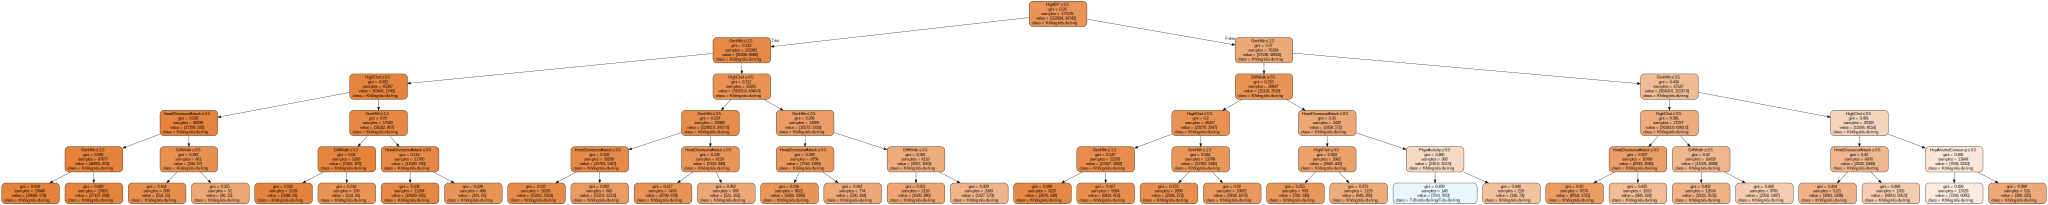


Điểm Cross-validation (5 fold): [0.86067092 0.86140019 0.86149874 0.86051325 0.86065121]
Điểm Cross-validation trung bình: 0.8609
\Tầm quan trọng của các đặc trưng theo Decision Tree:
HighBP                  0.472269
GenHlth                 0.383903
HighChol                0.092087
HeartDiseaseorAttack    0.022596
DiffWalk                0.020919
HvyAlcoholConsump       0.007204
PhysActivity            0.001022
Fruits                  0.000000
Stroke                  0.000000
Smoker                  0.000000
Veggies                 0.000000
NoDocbcCost             0.000000
AnyHealthcare           0.000000
MentHlth                0.000000
PhysHlth                0.000000
dtype: float64


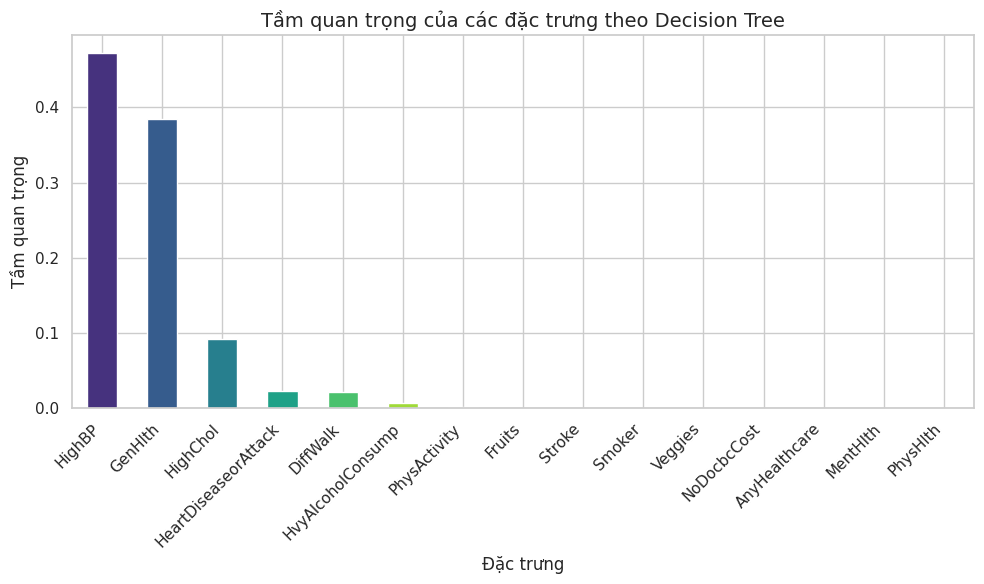

In [32]:
# prompt: Decision Tree nguy cơ tiểu đường theo lối sống

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import tree
import graphviz

# Prepare data for Decision Tree
# Features (X) are lifestyle factors, target (y) is Diabetes_binary
X_dt = df_lifestyle.drop('Diabetes_binary', axis=1)
y_dt = df_lifestyle['Diabetes_binary']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_dt, y_dt, test_size=0.3, random_state=42, stratify=y_dt) # Stratify to maintain class distribution

# Initialize the Decision Tree Classifier
# We can experiment with different parameters like max_depth, criterion, min_samples_split, etc.
dt_classifier = DecisionTreeClassifier(max_depth=5, random_state=42, criterion='gini') # Limiting depth for visualization and interpretability

# Train the Decision Tree model
dt_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nĐộ chính xác của mô hình Decision Tree: {accuracy:.4f}")

print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred, target_names=['Không tiểu đường', 'Tiền tiểu đường/Tiểu đường']))

print("\nMa trận nhầm lẫn:")
print(confusion_matrix(y_test, y_pred))

# Visualize the Decision Tree (Requires graphviz)
# You might need to install graphviz: !pip install graphviz
dot_data = tree.export_graphviz(dt_classifier,
                                feature_names=X_dt.columns,
                                class_names=['Không tiểu đường', 'Tiền tiểu đường/Tiểu đường'],
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)

print("\nCây quyết định:")
# Render the graph (this might display directly in Colab/Jupyter or save to a file)
graph.render("decision_tree_diabetes", format='png', cleanup=True) # Saves as decision_tree_diabetes.png
display(graph) # Displays the graph

# Cross-validation to get a more robust estimate of performance
cv_scores = cross_val_score(dt_classifier, X_dt, y_dt, cv=5) # 5-fold cross-validation
print(f"\nĐiểm Cross-validation (5 fold): {cv_scores}")
print(f"Điểm Cross-validation trung bình: {cv_scores.mean():.4f}")

# Feature Importances
print("\Tầm quan trọng của các đặc trưng theo Decision Tree:")
feature_importances = pd.Series(dt_classifier.feature_importances_, index=X_dt.columns).sort_values(ascending=False)
print(feature_importances)

# Plot feature importances
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar', color=sns.color_palette('viridis'))
plt.title('Tầm quan trọng của các đặc trưng theo Decision Tree', fontsize=14)
plt.xlabel('Đặc trưng', fontsize=12)
plt.ylabel('Tầm quan trọng', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Khai phá luật kết hợp với Apriori

In [33]:
# Biến đổi Dữ liệu sang dạng giao dịch (transaction)
# Xác định các cột lối sống

lifestyle_cols = ['HighBP', 'HighChol', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
                  'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump',
                  'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth',
                  'DiffWalk', 'Diabetes_binary']

In [34]:
# Make a copy to avoid modifying the original df_lifestyle
df_lifestyle_processed = df_lifestyle.copy()

# Discretize 'GenHlth' (already somewhat ordinal, but mapping to descriptive categories)
genhlth_map_processed = {
    1: 'GenHlth_Excellent', 2: 'GenHlth_Very_Good', 3: 'GenHlth_Good',
    4: 'GenHlth_Fair', 5: 'GenHlth_Poor'
}
df_lifestyle_processed['GenHlth'] = df_lifestyle_processed['GenHlth'].map(genhlth_map_processed)

# Discretize 'MentHlth' (number of days with poor mental health)
# Define bins based on the distribution observed earlier (0, 1-5, 6-15, >15)
menthlth_bins = [-1, 0, 5, 15, 30]
menthlth_labels = ['MentHlth_0_days', 'MentHlth_1_5_days', 'MentHlth_6_15_days', 'MentHlth_Over_15_days']
df_lifestyle_processed['MentHlth'] = pd.cut(df_lifestyle_processed['MentHlth'], bins=menthlth_bins, labels=menthlth_labels, right=True)

# Discretize 'PhysHlth' (number of days with poor physical health)
# Define bins similar to MentHlth
physhlth_bins = [-1, 0, 5, 15, 30]
physhlth_labels = ['PhysHlth_0_days', 'PhysHlth_1_5_days', 'PhysHlth_6_15_days', 'PhysHlth_Over_15_days']
df_lifestyle_processed['PhysHlth'] = pd.cut(df_lifestyle_processed['PhysHlth'], bins=physhlth_bins, labels=physhlth_labels, right=True)


# Convert binary columns to descriptive categories
binary_cols = ['HighBP', 'HighChol', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
               'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump',
               'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Diabetes_binary']

for col in binary_cols:
    df_lifestyle_processed[col] = df_lifestyle_processed[col].map({0: f'{col}_No', 1: f'{col}_Yes'})

# Drop the original target variable as it's not a lifestyle factor for finding general associations
# df_lifestyle_processed = df_lifestyle_processed.drop('Diabetes_binary', axis=1)

# Convert the DataFrame to a list of lists (transactions)
# Drop any rows with NaN values that might have resulted from mapping/cutting if not all values were covered
transactions_lifestyle_processed = df_lifestyle_processed.dropna().astype(str).values.tolist()

print("Đã làm sạch và phân loại dữ liệu lối sống. Sẵn sàng cho Apriori.")
# Display the first few processed transactions
transactions_lifestyle_processed[:5]

Đã làm sạch và phân loại dữ liệu lối sống. Sẵn sàng cho Apriori.


[['HighBP_Yes',
  'HighChol_Yes',
  'Smoker_Yes',
  'Stroke_No',
  'HeartDiseaseorAttack_No',
  'PhysActivity_No',
  'Fruits_No',
  'Veggies_Yes',
  'HvyAlcoholConsump_No',
  'AnyHealthcare_Yes',
  'NoDocbcCost_No',
  'GenHlth_Poor',
  'MentHlth_Over_15_days',
  'PhysHlth_6_15_days',
  'DiffWalk_Yes',
  'Diabetes_binary_No'],
 ['HighBP_No',
  'HighChol_No',
  'Smoker_Yes',
  'Stroke_No',
  'HeartDiseaseorAttack_No',
  'PhysActivity_Yes',
  'Fruits_No',
  'Veggies_No',
  'HvyAlcoholConsump_No',
  'AnyHealthcare_No',
  'NoDocbcCost_Yes',
  'GenHlth_Good',
  'MentHlth_0_days',
  'PhysHlth_0_days',
  'DiffWalk_No',
  'Diabetes_binary_No'],
 ['HighBP_Yes',
  'HighChol_Yes',
  'Smoker_No',
  'Stroke_No',
  'HeartDiseaseorAttack_No',
  'PhysActivity_No',
  'Fruits_Yes',
  'Veggies_No',
  'HvyAlcoholConsump_No',
  'AnyHealthcare_Yes',
  'NoDocbcCost_Yes',
  'GenHlth_Poor',
  'MentHlth_Over_15_days',
  'PhysHlth_Over_15_days',
  'DiffWalk_Yes',
  'Diabetes_binary_No'],
 ['HighBP_Yes',
  'HighCh

In [35]:
# Convert the DataFrame to a list of lists (transactions)
# Use the processed lifestyle data
transactions_lifestyle_processed = df_lifestyle_processed.values.tolist()

print("Đã tạo danh sách giao dịch từ dữ liệu lối sống đã xử lý.")
# Display the first few processed transactions
transactions_lifestyle_processed[:5]

Đã tạo danh sách giao dịch từ dữ liệu lối sống đã xử lý.


[['HighBP_Yes',
  'HighChol_Yes',
  'Smoker_Yes',
  'Stroke_No',
  'HeartDiseaseorAttack_No',
  'PhysActivity_No',
  'Fruits_No',
  'Veggies_Yes',
  'HvyAlcoholConsump_No',
  'AnyHealthcare_Yes',
  'NoDocbcCost_No',
  'GenHlth_Poor',
  'MentHlth_Over_15_days',
  'PhysHlth_6_15_days',
  'DiffWalk_Yes',
  'Diabetes_binary_No'],
 ['HighBP_No',
  'HighChol_No',
  'Smoker_Yes',
  'Stroke_No',
  'HeartDiseaseorAttack_No',
  'PhysActivity_Yes',
  'Fruits_No',
  'Veggies_No',
  'HvyAlcoholConsump_No',
  'AnyHealthcare_No',
  'NoDocbcCost_Yes',
  'GenHlth_Good',
  'MentHlth_0_days',
  'PhysHlth_0_days',
  'DiffWalk_No',
  'Diabetes_binary_No'],
 ['HighBP_Yes',
  'HighChol_Yes',
  'Smoker_No',
  'Stroke_No',
  'HeartDiseaseorAttack_No',
  'PhysActivity_No',
  'Fruits_Yes',
  'Veggies_No',
  'HvyAlcoholConsump_No',
  'AnyHealthcare_Yes',
  'NoDocbcCost_Yes',
  'GenHlth_Poor',
  'MentHlth_Over_15_days',
  'PhysHlth_Over_15_days',
  'DiffWalk_Yes',
  'Diabetes_binary_No'],
 ['HighBP_Yes',
  'HighCh

In [36]:
#Chuyển đổi dữ liệu lối sống sang dạng mã hóa one-hot

# Apply TransactionEncoder to convert the list of transactions into a one-hot encoded DataFrame
te_lifestyle = TransactionEncoder()
te_ary_lifestyle = te_lifestyle.fit(transactions_lifestyle_processed).transform(transactions_lifestyle_processed)
df_lifestyle_encoded = pd.DataFrame(te_ary_lifestyle, columns=te_lifestyle.columns_)

print("Đã chuyển đổi dữ liệu lối sống sang dạng mã hóa one-hot.")
# Display the first few rows of the one-hot encoded DataFrame
df_lifestyle_encoded.head()

Đã chuyển đổi dữ liệu lối sống sang dạng mã hóa one-hot.


,AnyHealthcare_No,AnyHealthcare_Yes,Diabetes_binary_No,Diabetes_binary_Yes,DiffWalk_No,DiffWalk_Yes,Fruits_No,Fruits_Yes,GenHlth_Excellent,GenHlth_Fair,...,PhysHlth_0_days,PhysHlth_1_5_days,PhysHlth_6_15_days,PhysHlth_Over_15_days,Smoker_No,Smoker_Yes,Stroke_No,Stroke_Yes,Veggies_No,Veggies_Yes
0,False,True,True,False,False,True,True,False,False,False,...,False,False,True,False,False,True,True,False,False,True
1,True,False,True,False,True,False,True,False,False,False,...,True,False,False,False,False,True,True,False,True,False
2,False,True,True,False,False,True,False,True,False,False,...,False,False,False,True,True,False,True,False,True,False
3,False,True,True,False,True,False,False,True,False,False,...,True,False,False,False,True,False,True,False,False,True
4,False,True,True,False,True,False,False,True,False,False,...,True,False,False,False,True,False,True,False,False,True


In [37]:
# Chạy Apriori

# Apply the Apriori algorithm to find frequent itemsets
# min_support is a key parameter - adjust based on desired frequency
frequent_itemsets_lifestyle = apriori(df_lifestyle_encoded, min_support=0.25, use_colnames=True)

# print("Đã tìm thấy các tập mục phổ biến từ dữ liệu lối sống.")
# Display the frequent itemsets
frequent_itemsets_lifestyle

,support,itemsets
0,0.951053,(AnyHealthcare_Yes)
1,0.860667,(Diabetes_binary_No)
2,0.831776,(DiffWalk_No)
3,0.365744,(Fruits_No)
4,0.634256,(Fruits_Yes)
...,...,...
10775,0.259666,"(PhysActivity_Yes, DiffWalk_No, MentHlth_0_day..."
10776,0.255917,"(PhysActivity_Yes, DiffWalk_No, MentHlth_0_day..."
10777,0.252456,"(PhysActivity_Yes, MentHlth_0_days, HvyAlcohol..."
10778,0.264790,"(PhysActivity_Yes, DiffWalk_No, MentHlth_0_day..."


In [38]:
# Tạo luật kết hợp

from mlxtend.frequent_patterns import association_rules

# Generate association rules from the frequent itemsets
# metric can be 'support', 'confidence', 'lift', etc.
# min_threshold is the minimum value for the chosen metric
rules_lifestyle = association_rules(frequent_itemsets_lifestyle, metric="lift", min_threshold=1.0)

# print("Đã tạo các luật kết hợp từ dữ liệu lối sống.")
# Display the generated rules
rules_lifestyle.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(AnyHealthcare_Yes),(Fruits_Yes),0.951053,0.634256,0.606488,0.637702,1.005434,1.0,0.003278,1.009513,0.110421,0.619612,0.009424,0.796962
1,(Fruits_Yes),(AnyHealthcare_Yes),0.634256,0.951053,0.606488,0.956221,1.005434,1.0,0.003278,1.118051,0.014778,0.619612,0.105587,0.796962
2,(GenHlth_Very_Good),(AnyHealthcare_Yes),0.351167,0.951053,0.337563,0.961261,1.010734,1.0,0.003585,1.263529,0.016368,0.349931,0.208566,0.658099
3,(AnyHealthcare_Yes),(GenHlth_Very_Good),0.951053,0.351167,0.337563,0.354936,1.010734,1.0,0.003585,1.005844,0.216971,0.349931,0.005810,0.658099
4,(AnyHealthcare_Yes),(HighBP_Yes),0.951053,0.429001,0.412106,0.433316,1.010057,1.0,0.004103,1.007613,0.203417,0.425752,0.007556,0.696966
5,(HighBP_Yes),(AnyHealthcare_Yes),0.429001,0.951053,0.412106,0.960617,1.010057,1.0,0.004103,1.242862,0.017437,0.425752,0.195405,0.696966
6,(AnyHealthcare_Yes),(HighChol_Yes),0.951053,0.424121,0.407864,0.428856,1.011164,1.0,0.004503,1.008290,0.225555,0.421648,0.008222,0.695263
7,(HighChol_Yes),(AnyHealthcare_Yes),0.424121,0.951053,0.407864,0.961670,1.011164,1.0,0.004503,1.276991,0.019171,0.421648,0.216909,0.695263
8,(AnyHealthcare_Yes),(HvyAlcoholConsump_No),0.951053,0.943803,0.898128,0.944351,1.000581,1.0,0.000521,1.009847,0.011855,0.901076,0.009751,0.947978
9,(HvyAlcoholConsump_No),(AnyHealthcare_Yes),0.943803,0.951053,0.898128,0.951605,1.000581,1.0,0.000521,1.011410,0.010325,0.901076,0.011281,0.947978


In [39]:
r=rules_lifestyle.sort_values(by='lift', ascending=False).head()

for index, row in r.iterrows():
    antecedents = list(row['antecedents'])
    consequents = list(row['consequents'])
    support = row['support']
    confidence = row['confidence']
    lift = row['lift']
    print(f"Luật: {antecedents} => {consequents}")
    print(f"  Support: {support:.4f}")
    print(f"  Confidence: {confidence:.4f}")
    print(f"  Lift: {lift:.4f}")
    print("-" * 20)

Luật: ['PhysHlth_0_days', 'HighBP_No', 'HeartDiseaseorAttack_No'] => ['Diabetes_binary_No', 'DiffWalk_No', 'HighChol_No', 'Stroke_No']
  Support: 0.2585
  Confidence: 0.6840
  Lift: 1.4631
--------------------
Luật: ['Diabetes_binary_No', 'DiffWalk_No', 'HighChol_No', 'Stroke_No'] => ['PhysHlth_0_days', 'HighBP_No', 'HeartDiseaseorAttack_No']
  Support: 0.2585
  Confidence: 0.5529
  Lift: 1.4631
--------------------
Luật: ['DiffWalk_No', 'Diabetes_binary_No', 'HighChol_No', 'Veggies_Yes', 'Stroke_No'] => ['PhysActivity_Yes', 'HighBP_No', 'HeartDiseaseorAttack_No']
  Support: 0.2538
  Confidence: 0.6472
  Lift: 1.4624
--------------------
Luật: ['PhysActivity_Yes', 'HighBP_No', 'HeartDiseaseorAttack_No'] => ['DiffWalk_No', 'Diabetes_binary_No', 'HighChol_No', 'Veggies_Yes', 'Stroke_No']
  Support: 0.2538
  Confidence: 0.5736
  Lift: 1.4624
--------------------
Luật: ['PhysActivity_Yes', 'Stroke_No', 'HighBP_No', 'HeartDiseaseorAttack_No'] => ['Veggies_Yes', 'Diabetes_binary_No', 'DiffWa

In [40]:
# Display the top 5 rules sorted by support
print("Top 5 luật kết hợp liên quan đến Lối sống theo support:")
top_5_lifestyle_rules_by_support = rules_lifestyle.sort_values(by='support', ascending=False).head(5)
top_5_lifestyle_rules_by_support

# for index, row in top_5_lifestyle_rules_by_support.iterrows():
#     antecedents = list(row['antecedents'])
#     consequents = list(row['consequents'])
#     support = row['support']
#     confidence = row['confidence']
#     lift = row['lift']
#     print(f"Luật: {antecedents} => {consequents}")
#     print(f"  Support: {support:.4f}")
#     print(f"  Confidence: {confidence:.4f}")
#     print(f"  Lift: {lift:.4f}")
#     print("-" * 20)

Top 5 luật kết hợp liên quan đến Lối sống theo support:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
8,(AnyHealthcare_Yes),(HvyAlcoholConsump_No),0.951053,0.943803,0.898128,0.944351,1.000581,1.0,0.000521,1.009847,0.011855,0.901076,0.009751,0.947978
9,(HvyAlcoholConsump_No),(AnyHealthcare_Yes),0.943803,0.951053,0.898128,0.951605,1.000581,1.0,0.000521,1.011410,0.010325,0.901076,0.011281,0.947978
12,(AnyHealthcare_Yes),(NoDocbcCost_No),0.951053,0.915823,0.884926,0.930470,1.015993,1.0,0.013930,1.210657,0.321599,0.901193,0.174002,0.948366
13,(NoDocbcCost_No),(AnyHealthcare_Yes),0.915823,0.951053,0.884926,0.966263,1.015993,1.0,0.013930,1.450852,0.187005,0.901193,0.310750,0.948366
125,(HeartDiseaseorAttack_No),(Stroke_No),0.905814,0.959429,0.880763,0.972344,1.013461,1.0,0.011698,1.466977,0.141020,0.894648,0.318326,0.945176


In [41]:
top_5_lifestyle_rules_by_lift = rules_lifestyle.sort_values(by='lift', ascending=False).head(5)

for index, row in top_5_lifestyle_rules_by_lift.iterrows():
    antecedents = list(row['antecedents'])
    consequents = list(row['consequents'])
    support = row['support']
    confidence = row['confidence']
    lift = row['lift']
    print(f"Luật: {antecedents} => {consequents}")
    print(f"  Support: {support:.4f}")
    print(f"  Confidence: {confidence:.4f}")
    print(f"  Lift: {lift:.4f}")
    print("-" * 20)

top_5_lifestyle_rules_by_lift


Luật: ['PhysHlth_0_days', 'HighBP_No', 'HeartDiseaseorAttack_No'] => ['Diabetes_binary_No', 'DiffWalk_No', 'HighChol_No', 'Stroke_No']
  Support: 0.2585
  Confidence: 0.6840
  Lift: 1.4631
--------------------
Luật: ['Diabetes_binary_No', 'DiffWalk_No', 'HighChol_No', 'Stroke_No'] => ['PhysHlth_0_days', 'HighBP_No', 'HeartDiseaseorAttack_No']
  Support: 0.2585
  Confidence: 0.5529
  Lift: 1.4631
--------------------
Luật: ['DiffWalk_No', 'Diabetes_binary_No', 'HighChol_No', 'Veggies_Yes', 'Stroke_No'] => ['PhysActivity_Yes', 'HighBP_No', 'HeartDiseaseorAttack_No']
  Support: 0.2538
  Confidence: 0.6472
  Lift: 1.4624
--------------------
Luật: ['PhysActivity_Yes', 'HighBP_No', 'HeartDiseaseorAttack_No'] => ['DiffWalk_No', 'Diabetes_binary_No', 'HighChol_No', 'Veggies_Yes', 'Stroke_No']
  Support: 0.2538
  Confidence: 0.5736
  Lift: 1.4624
--------------------
Luật: ['PhysActivity_Yes', 'Stroke_No', 'HighBP_No', 'HeartDiseaseorAttack_No'] => ['Veggies_Yes', 'Diabetes_binary_No', 'DiffWa

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
428770,"(PhysHlth_0_days, HighBP_No, HeartDiseaseorAtt...","(Diabetes_binary_No, DiffWalk_No, HighChol_No,...",0.377913,0.467479,0.258475,0.683954,1.463070,1.0,0.081809,1.684949,0.508781,0.440395,0.406510,0.618434
428707,"(Diabetes_binary_No, DiffWalk_No, HighChol_No,...","(PhysHlth_0_days, HighBP_No, HeartDiseaseorAtt...",0.467479,0.377913,0.258475,0.552913,1.463070,1.0,0.081809,1.391424,0.594353,0.440395,0.281312,0.618434
690987,"(DiffWalk_No, Diabetes_binary_No, HighChol_No,...","(PhysActivity_Yes, HighBP_No, HeartDiseaseorAt...",0.392199,0.442522,0.253812,0.647151,1.462415,1.0,0.080255,1.579934,0.520235,0.436922,0.367062,0.610354
691094,"(PhysActivity_Yes, HighBP_No, HeartDiseaseorAt...","(DiffWalk_No, Diabetes_binary_No, HighChol_No,...",0.442522,0.392199,0.253812,0.573558,1.462415,1.0,0.080255,1.425283,0.567197,0.436922,0.298385,0.610354
691040,"(PhysActivity_Yes, Stroke_No, HighBP_No, Heart...","(Veggies_Yes, Diabetes_binary_No, DiffWalk_No,...",0.437342,0.397453,0.253812,0.580351,1.460172,1.0,0.079989,1.435833,0.560109,0.436866,0.303540,0.609473


In [42]:
# Filter rules containing Diabetes_binary in either antecedents or consequents
rules_diabetes = rules_lifestyle[
    rules_lifestyle['antecedents'].apply(lambda x: 'Diabetes_binary_No' in x or 'Diabetes_binary_Yes' in x) |
    rules_lifestyle['consequents'].apply(lambda x: 'Diabetes_binary_No' in x or 'Diabetes_binary_Yes' in x)
]

# Display the top 5 filtered rules sorted by lift
print("Top 5 luật kết hợp liên quan đến Tiểu đường theo lift:")
top_5_diabetes_rules = rules_diabetes.sort_values(by='lift', ascending=False).head(5)

for index, row in top_5_diabetes_rules.iterrows():
    antecedents = list(row['antecedents'])
    consequents = list(row['consequents'])
    support = row['support']
    confidence = row['confidence']
    lift = row['lift']
    print(f"Luật: {antecedents} => {consequents}")
    print(f"  Support: {support:.4f}")
    print(f"  Confidence: {confidence:.4f}")
    print(f"  Lift: {lift:.4f}")
    print("-" * 20)

Top 5 luật kết hợp liên quan đến Tiểu đường theo lift:
Luật: ['PhysHlth_0_days', 'HighBP_No', 'HeartDiseaseorAttack_No'] => ['Diabetes_binary_No', 'DiffWalk_No', 'HighChol_No', 'Stroke_No']
  Support: 0.2585
  Confidence: 0.6840
  Lift: 1.4631
--------------------
Luật: ['Diabetes_binary_No', 'DiffWalk_No', 'HighChol_No', 'Stroke_No'] => ['PhysHlth_0_days', 'HighBP_No', 'HeartDiseaseorAttack_No']
  Support: 0.2585
  Confidence: 0.5529
  Lift: 1.4631
--------------------
Luật: ['DiffWalk_No', 'Diabetes_binary_No', 'HighChol_No', 'Veggies_Yes', 'Stroke_No'] => ['PhysActivity_Yes', 'HighBP_No', 'HeartDiseaseorAttack_No']
  Support: 0.2538
  Confidence: 0.6472
  Lift: 1.4624
--------------------
Luật: ['PhysActivity_Yes', 'HighBP_No', 'HeartDiseaseorAttack_No'] => ['DiffWalk_No', 'Diabetes_binary_No', 'HighChol_No', 'Veggies_Yes', 'Stroke_No']
  Support: 0.2538
  Confidence: 0.5736
  Lift: 1.4624
--------------------
Luật: ['PhysActivity_Yes', 'Stroke_No', 'HighBP_No', 'HeartDiseaseorAttac

In [43]:
top_5_diabetes_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
428770,"(PhysHlth_0_days, HighBP_No, HeartDiseaseorAtt...","(Diabetes_binary_No, DiffWalk_No, HighChol_No,...",0.377913,0.467479,0.258475,0.683954,1.463070,1.0,0.081809,1.684949,0.508781,0.440395,0.406510,0.618434
428707,"(Diabetes_binary_No, DiffWalk_No, HighChol_No,...","(PhysHlth_0_days, HighBP_No, HeartDiseaseorAtt...",0.467479,0.377913,0.258475,0.552913,1.463070,1.0,0.081809,1.391424,0.594353,0.440395,0.281312,0.618434
690987,"(DiffWalk_No, Diabetes_binary_No, HighChol_No,...","(PhysActivity_Yes, HighBP_No, HeartDiseaseorAt...",0.392199,0.442522,0.253812,0.647151,1.462415,1.0,0.080255,1.579934,0.520235,0.436922,0.367062,0.610354
691094,"(PhysActivity_Yes, HighBP_No, HeartDiseaseorAt...","(DiffWalk_No, Diabetes_binary_No, HighChol_No,...",0.442522,0.392199,0.253812,0.573558,1.462415,1.0,0.080255,1.425283,0.567197,0.436922,0.298385,0.610354
691040,"(PhysActivity_Yes, Stroke_No, HighBP_No, Heart...","(Veggies_Yes, Diabetes_binary_No, DiffWalk_No,...",0.437342,0.397453,0.253812,0.580351,1.460172,1.0,0.079989,1.435833,0.560109,0.436866,0.303540,0.609473


# **Mục tiêu khai phá 2:** Phân tích xu hướng bệnh tiểu đường theo các nhóm nhân khẩu học (Q.Thắng)

##1.1 Copy dữ liệu và tổng quan


In [44]:
t2_df=df.copy()


## 1.2 Phân tích tỷ lệ tiểu đường theo độ tuổi, giới tính, thu nhập

###1.2.1 Tỷ lệ mắc bệnh theo độ tuổi

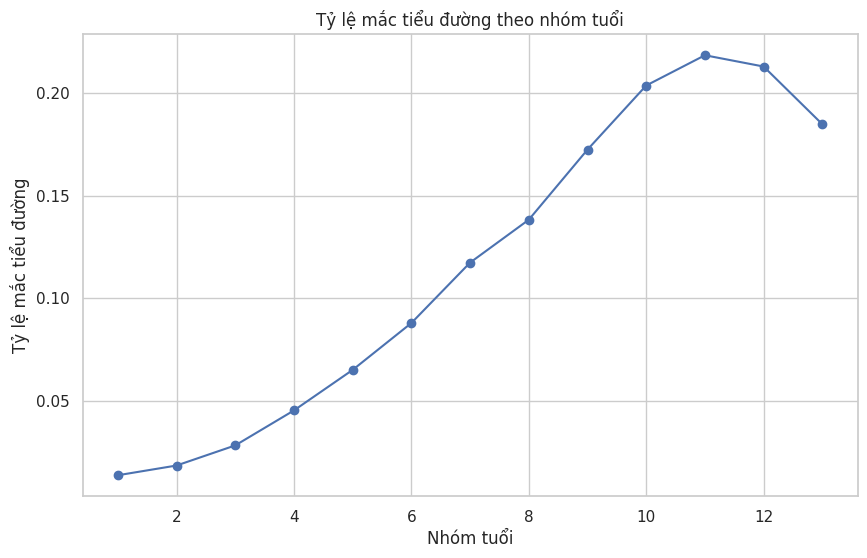

In [45]:
# Tính tỷ lệ mắc tiểu đường trung bình theo nhóm tuổi
age_group = t2_df.groupby("Age")["Diabetes_binary"].mean()

# Vẽ biểu đồ đường thể hiện xu hướng theo tuổi
plt.figure(figsize=(10, 6))
age_group.plot(kind="line", marker="o")
plt.title("Tỷ lệ mắc tiểu đường theo nhóm tuổi")
plt.xlabel("Nhóm tuổi")
plt.ylabel("Tỷ lệ mắc tiểu đường")
plt.grid(True)
plt.show()


###1.2.2 Tỷ lệ mắc bệnh theo giới tính và thu nhập

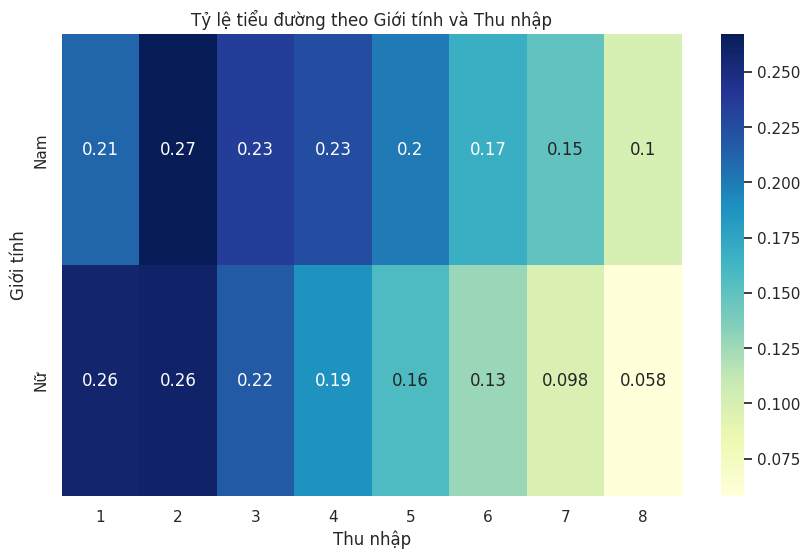

In [46]:
# Tính tỷ lệ mắc bệnh theo giới tính và thu nhập
pivot = t2_df.groupby(["Sex", "Income"])["Diabetes_binary"].mean().reset_index()

# Đổi cột cho dễ hiểu
pivot["Sex"] = pivot["Sex"].replace({0: "Nữ", 1: "Nam"})

# Vẽ heatmap thể hiện mối quan hệ giữa giới tính, thu nhập và bệnh tiểu đường
heat_data = pivot.pivot_table(index="Sex", columns="Income", values="Diabetes_binary")
plt.figure(figsize=(10,6))
sns.heatmap(heat_data, annot=True, cmap="YlGnBu")
plt.title("Tỷ lệ tiểu đường theo Giới tính và Thu nhập")
plt.xlabel("Thu nhập")
plt.ylabel("Giới tính")
plt.show()

###1.2.3 Biểu đồ stacked bar: Giới tính & Tình trạng bệnh

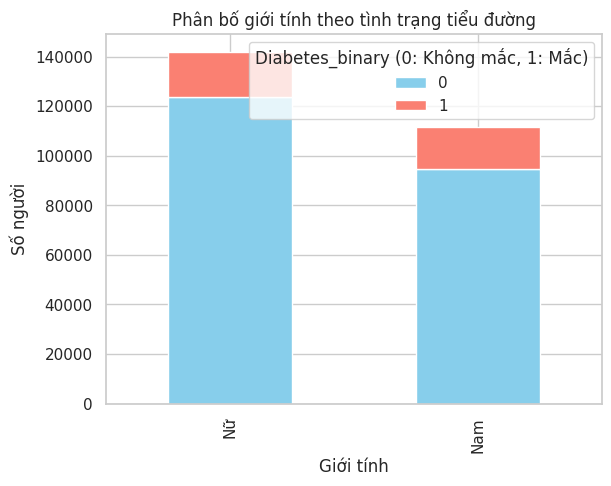

In [47]:
# Tạo bảng đếm số lượng theo giới và tình trạng
gender_disease = t2_df.groupby(['Sex', 'Diabetes_binary']).size().unstack()

# Đổi tên giới tính
gender_disease.index = gender_disease.index.map({0: "Nữ", 1: "Nam"})

# Biểu đồ stacked bar
gender_disease.plot(kind='bar', stacked=True, color=["skyblue", "salmon"])
plt.title("Phân bố giới tính theo tình trạng tiểu đường")
plt.legend(title="Diabetes_binary (0: Không mắc, 1: Mắc)")
plt.xlabel("Giới tính")
plt.ylabel("Số người")
plt.show()


/tmp/ipython-input-48-2839342245.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=t2_df, x="Diabetes_binary", y="BMI", palette="Set2")


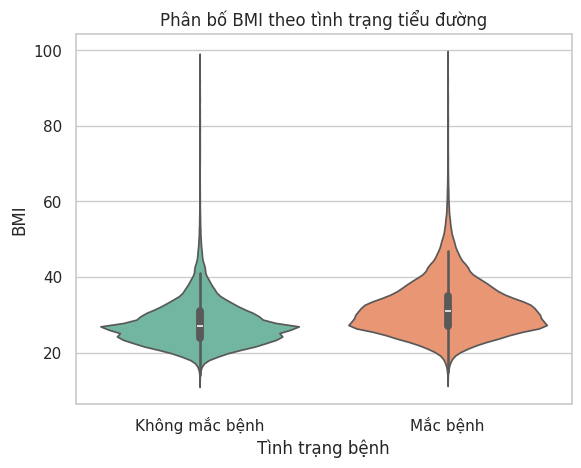

In [48]:
#Phân bố BMI theo tình trạng tiểu đường
sns.violinplot(data=t2_df, x="Diabetes_binary", y="BMI", palette="Set2")
plt.xticks([0,1], ['Không mắc bệnh', 'Mắc bệnh'])
plt.title("Phân bố BMI theo tình trạng tiểu đường")
plt.xlabel("Tình trạng bệnh")
plt.ylabel("BMI")
plt.show()


###1.2.4 Phân tích theo trình độ học vấn và thu nhập (Heatmap)

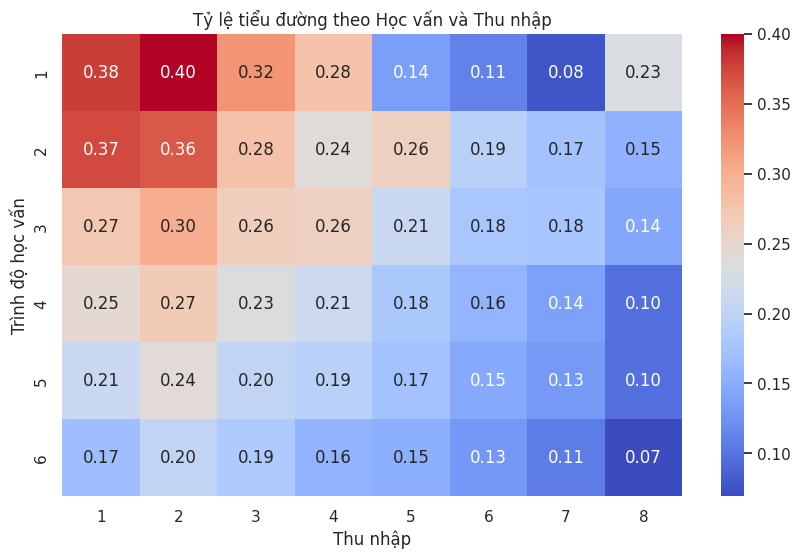

In [49]:
# Gom nhóm theo Education và Income để tính tỷ lệ mắc bệnh
edu_income = t2_df.groupby(["Education", "Income"])["Diabetes_binary"].mean().unstack()

plt.figure(figsize=(10,6))
sns.heatmap(edu_income, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Tỷ lệ tiểu đường theo Học vấn và Thu nhập")
plt.xlabel("Thu nhập")
plt.ylabel("Trình độ học vấn")
plt.show()


##1.3 Cây quyết định (Decision Tree)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.86      1.00      0.93     65605
           1       0.00      0.00      0.00     10499

    accuracy                           0.86     76104
   macro avg       0.43      0.50      0.46     76104
weighted avg       0.74      0.86      0.80     76104



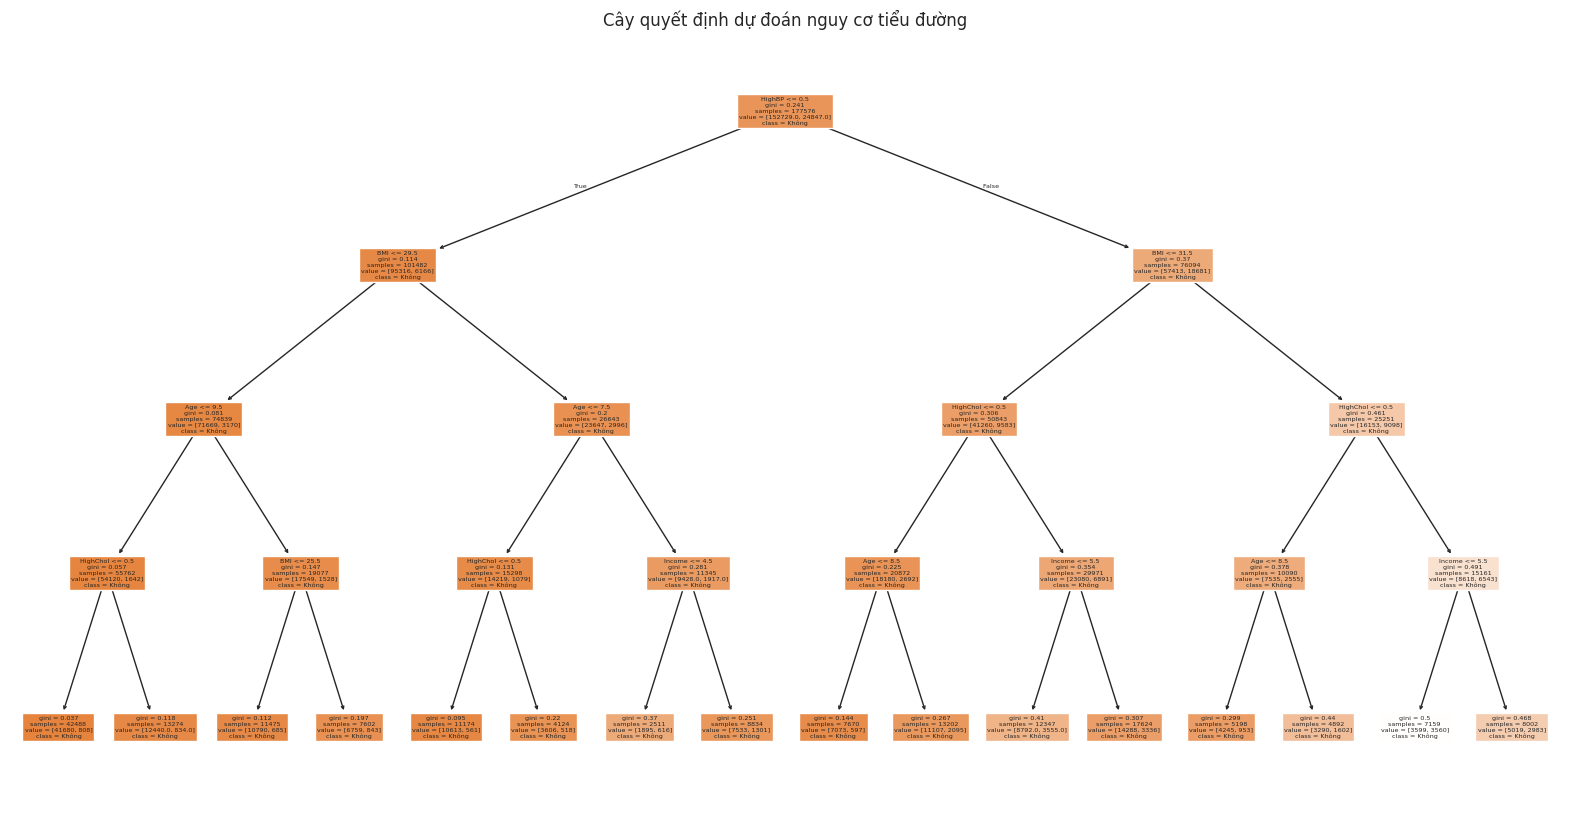

In [50]:
# Chọn một số đặc trưng nhân khẩu học
features = ["BMI", "Age", "Income", "Education", "HighBP", "HighChol", "Smoker", "PhysActivity", "Fruits", "Veggies", "HvyAlcoholConsump"]
X = t2_df[features]
y = t2_df["Diabetes_binary"]

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Huấn luyện cây quyết định
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(X_train, y_train)
# Đánh giá mô hình
y_pred = tree.predict(X_test)
print(classification_report(y_test, y_pred))
# Vẽ cây
plt.figure(figsize=(20,10))
plot_tree(tree, feature_names=features, class_names=["Không", "Tiểu đường"], filled=True)
plt.title("Cây quyết định dự đoán nguy cơ tiểu đường")
plt.show()


##2 Tiền xử lý dữ liệu trước khi khai phá với Apriori

###2.1 Xác định các cột nhân khẩu học

| Cột         | Mô tả            |
| ----------- | ---------------- |
| `Sex`       | Giới tính        |
| `Age`       | Tuổi             |
| `Education` | Trình độ học vấn |
| `Income`    | Thu nhập         |


In [51]:
t2_df = df[['Sex', 'Age', 'Education', 'Income', 'Diabetes_binary']].copy()

###2.2 Tiền xử lý: làm sạch và phân loại

Chuyển về định dạng phân loại (categorical)
Apriori yêu cầu dữ liệu rời rạc (categorical).

Với các cột dạng số như Age, Education, Income → ta cần phân nhóm.

###2.2.1 Age → nhóm tuổi:

| Mã | Nhóm tuổi |
| -- | --------- |
| 1  | 18–24     |
| 2  | 25–29     |
| 3  | 30–34     |
| 4  | 35–39     |
| 5  | 40–44     |
| 6  | 45–49     |
| 7  | 50–54     |
| 8  | 55–59     |
| 9  | 60–64     |
| 10 | 65–69     |
| 11 | 70–74     |
| 12 | 75–79     |
| 13 | 80+       |


In [52]:
age_map = {
    1: 'Age_18_24', 2: 'Age_25_29', 3: 'Age_30_34',
    4: 'Age_35_39', 5: 'Age_40_44', 6: 'Age_45_49',
    7: 'Age_50_54', 8: 'Age_55_59', 9: 'Age_60_64',
    10: 'Age_65_69', 11: 'Age_70_74', 12: 'Age_75_79', 13: 'Age_80_plus'
}
t2_df['Age'] = t2_df['Age'].map(age_map)


###2.2.2 Education → nhóm trình độ học vấn:

| Mã | Trình độ                            |
| -- | ----------------------------------- |
| 1  | Không học (Never attended)          |
| 2  | Lớp 1–8 (Primary)                   |
| 3  | Lớp 9–11 (Some High School)         |
| 4  | Tốt nghiệp cấp 3 (High School Grad) |
| 5  | Học cao đẳng (Some College)         |
| 6  | Cử nhân (College Grad)              |
| 7  | Sau đại học (Advanced degree)       |


In [53]:
edu_map = {
    1: 'Edu_None', 2: 'Edu_Primary', 3: 'Edu_HighSchool_Some',
    4: 'Edu_HighSchool_Grad', 5: 'Edu_College_Some',
    6: 'Edu_College_Grad', 7: 'Edu_Advanced'
}
t2_df['Education'] = t2_df['Education'].map(edu_map)

###2.2.3 Income → nhóm thu nhập:

| Mã | Mức thu nhập hàng năm |
| -- | --------------------- |
| 1  | < \$10,000            |
| 2  | \$10,000–\$15,000     |
| 3  | \$15,000–\$20,000     |
| 4  | \$20,000–\$25,000     |
| 5  | \$25,000–\$35,000     |
| 6  | \$35,000–\$50,000     |
| 7  | \$50,000–\$75,000     |
| 8  | > \$75,000            |


In [54]:
income_map = {
    1: 'Inc_<10k', 2: 'Inc_10_15k', 3: 'Inc_15_20k', 4: 'Inc_20_25k',
    5: 'Inc_25_35k', 6: 'Inc_35_50k', 7: 'Inc_50_75k', 8: 'Inc_75k_plus'
}
t2_df['Income'] = t2_df['Income'].map(income_map)

###2.2.4 Sex → nhóm giới tính

| Mã | Giới tính |
| -- | --------- |
| 0  | Nữ        |
| 1  | Nam       |

In [55]:
t2_df['Sex'] = t2_df['Sex'].map({0: 'Female', 1: 'Male'})

In [56]:
t2_df['Diabetes_binary'] = t2_df['Diabetes_binary'].map({0: 'not_diabetic', 1: 'diabetic'})

###2.3 Tạo danh sách giao dịch (transactions)

In [57]:
transactions = t2_df[['Sex', 'Age', 'Education', 'Income','Diabetes_binary']].astype(str).values.tolist()


###2.4 Chuyển sang dạng one-hot

In [58]:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

###2.5 Chạy Apriori

In [59]:
frequent_itemsets = apriori(df_encoded, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

###2.6 In luật kết hợp

In [60]:
def print_rule(rule):
  for index, row in rule.iterrows():
      antecedents = list(row['antecedents'])
      consequents = list(row['consequents'])
      support = row['support']
      confidence = row['confidence']
      lift = row['lift']
      print(f"Luật: {antecedents} => {consequents}")
      print(f"  Support: {support:.4f}")
      print(f"  Confidence: {confidence:.4f}")
      print(f"  Lift: {lift:.4f}")
      print("-" * 20)

In [61]:
param = ['antecedents', 'consequents', 'support', 'confidence', 'lift']
rules[param].head()

,antecedents,consequents,support,confidence,lift
0,(Age_35_39),(not_diabetic),0.052022,0.954713,1.109271
1,(Age_40_44),(not_diabetic),0.059547,0.934951,1.086310
2,(Age_45_49),(not_diabetic),0.071259,0.912105,1.059765
3,(Age_50_54),(not_diabetic),0.091556,0.882648,1.025540
4,(Age_55_59),(not_diabetic),0.104734,0.861735,1.001240


In [62]:
rules[param].sort_values(by='support', ascending=False).head()

,antecedents,consequents,support,confidence,lift
15,(Female),(not_diabetic),0.487082,0.870321,1.011217
10,(Edu_College_Grad),(not_diabetic),0.382076,0.903098,1.049300
21,(Male),(not_diabetic),0.373585,0.848397,0.985743
20,(Inc_75k_plus),(not_diabetic),0.327933,0.920396,1.069399
9,(Inc_75k_plus),(Edu_College_Grad),0.235805,0.661824,1.564329


In [63]:
rules[param].sort_values(by='lift', ascending=False).head()

,antecedents,consequents,support,confidence,lift
53,"(not_diabetic, Male, Edu_College_Grad)",(Inc_75k_plus),0.107643,0.625934,1.756784
30,"(Male, Edu_College_Grad)",(Inc_75k_plus),0.118504,0.607460,1.704935
50,"(Inc_75k_plus, Female)","(not_diabetic, Edu_College_Grad)",0.111712,0.634649,1.661056
33,(Inc_75k_plus),"(not_diabetic, Edu_College_Grad)",0.219355,0.615655,1.611343
48,"(Inc_75k_plus, Female, not_diabetic)",(Edu_College_Grad),0.111712,0.673856,1.592767


In [64]:
# Top 5 luật có độ lift cao nhất liên quan đến tiểu đường
rules_diabetes = rules[
    rules['antecedents'].apply(lambda x: 'not_diabetic' in x or 'diabetic' in x) |
    rules['consequents'].apply(lambda x: 'not_diabetic' in x or 'diabetic' in x)
]

print_rule(rules_diabetes[param].sort_values(by='lift', ascending=False).head())

Luật: ['not_diabetic', 'Male', 'Edu_College_Grad'] => ['Inc_75k_plus']
  Support: 0.1076
  Confidence: 0.6259
  Lift: 1.7568
--------------------
Luật: ['Inc_75k_plus', 'Female'] => ['not_diabetic', 'Edu_College_Grad']
  Support: 0.1117
  Confidence: 0.6346
  Lift: 1.6611
--------------------
Luật: ['Inc_75k_plus'] => ['not_diabetic', 'Edu_College_Grad']
  Support: 0.2194
  Confidence: 0.6157
  Lift: 1.6113
--------------------
Luật: ['Inc_75k_plus', 'Female', 'not_diabetic'] => ['Edu_College_Grad']
  Support: 0.1117
  Confidence: 0.6739
  Lift: 1.5928
--------------------
Luật: ['Inc_75k_plus', 'not_diabetic'] => ['Edu_College_Grad']
  Support: 0.2194
  Confidence: 0.6689
  Lift: 1.5811
--------------------


In [65]:
rules_diabetes[param].sort_values(by='lift', ascending=False).head()

,antecedents,consequents,support,confidence,lift
53,"(not_diabetic, Male, Edu_College_Grad)",(Inc_75k_plus),0.107643,0.625934,1.756784
50,"(Inc_75k_plus, Female)","(not_diabetic, Edu_College_Grad)",0.111712,0.634649,1.661056
33,(Inc_75k_plus),"(not_diabetic, Edu_College_Grad)",0.219355,0.615655,1.611343
48,"(Inc_75k_plus, Female, not_diabetic)",(Edu_College_Grad),0.111712,0.673856,1.592767
31,"(Inc_75k_plus, not_diabetic)",(Edu_College_Grad),0.219355,0.668903,1.581059


Tóm tắt pipeline tiền xử lý:

| Bước | Thao tác                                                   |
| ---- | ---------------------------------------------------------- |
| 1    | Dùng `.map()` để đổi mã số thành nhãn dễ hiểu              |
| 2    | Dùng `astype(str).values.tolist()` để tạo transaction list |
| 3    | Dùng Apriori để khai phá                                   |


# **Mục tiêu khai phá 3:** Dự đoán trạng thái bệnh tiểu đường (M.Thắng)


## 3.1 Huấn luyện các mô hình dạng cây (Tree-based)

In [66]:
t3_df=df.copy()

### 3.1.1 Tiền xử lý dữ liệu

In [67]:
# Kiểm tra missing value
t3_df.isnull().sum()

,0
HighBP,0
HighChol,0
CholCheck,0
BMI,0
Smoker,0
Stroke,0
HeartDiseaseorAttack,0
PhysActivity,0
Fruits,0
Veggies,0


/tmp/ipython-input-68-269278366.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=t3_df['BMI'], palette='viridis')


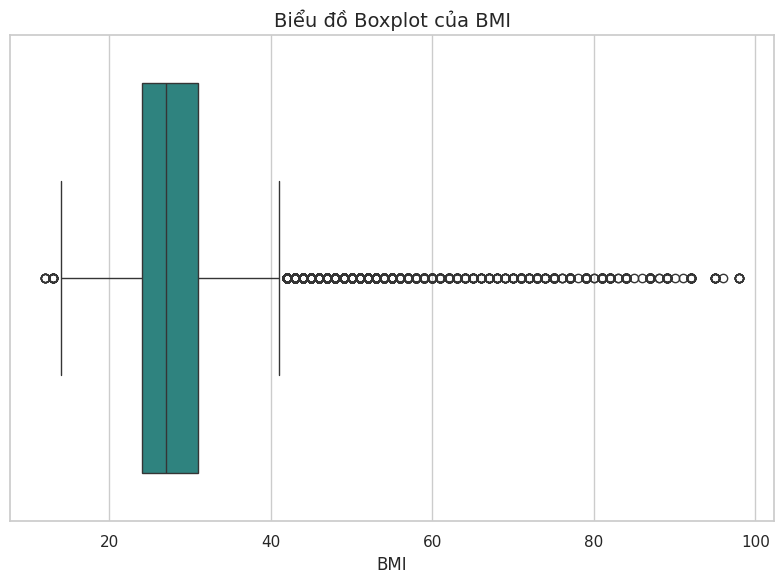

In [68]:
# Vẽ biểu đồ boxplot cho cột BMI để hình dung phân bố và ngoại lai
plt.figure(figsize=(8, 6))
sns.boxplot(x=t3_df['BMI'], palette='viridis')
plt.title('Biểu đồ Boxplot của BMI', fontsize=14)
plt.xlabel('BMI', fontsize=12)
plt.tight_layout()
plt.show()

Các giá trị BMI trên 50 là bất hợp lý về mặt y học có thể xem là outlier

In [69]:
# Xử lý các outlier ở cột BMI
# Tổng số dòng
total = len(t3_df)

# Số dòng có BMI > 60
bmi_over_50 = (t3_df['BMI'] > 50).sum()

# Tính phần trăm
percentage = (bmi_over_50 / total) * 100

print(f"Số dòng có BMI > 50: {bmi_over_50} / {total} ({percentage:.2f}%)")


Số dòng có BMI > 50: 2175 / 253680 (0.86%)


Vì số lượng outlier chiếm một phân rất nhỏ (< 1%) nên thực hiện xử lý bằng cắt ngưỡng (capping)

In [70]:
t3_df['BMI'] = t3_df['BMI'].apply(lambda x: min(x, 50))

### 3.1.2 Chia tập dữ liệu thành train và test

In [71]:
X = t3_df.drop('Diabetes_binary', axis=1)
y = t3_df['Diabetes_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3.1.3 Cân bằng dữ liệu

In [72]:
# Kiểm tra tập dữ liệu huấn luyện xem có cân bằng hay không
y_train.value_counts()

,count
Diabetes_binary,
0,174595
1,28349


Ta thấy dữ liệu mất cân bằng nghiêm trọng, cần xử lý để cân bằng dữ liệu

In [73]:
# Check the class distribution before SMOTE
print("Dữ liệu trước khi smote:")
print(Counter(y_train))

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("Dữ liệu sau khi smote:")
print(Counter(y_resampled))

Dữ liệu trước khi smote:
Counter({0: 174595, 1: 28349})
Dữ liệu sau khi smote:
Counter({0: 174595, 1: 174595})


### 3.1.4 Huấn luyện mô hình Decision Tree

In [74]:
# Hàm đánh giá mô hình
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Độ chính xác
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Độ chính xác: {accuracy:.4f}\n")

    # Báo cáo phân loại
    print("Báo cáo phân loại:")
    print(classification_report(y_test, y_pred, target_names=['Không tiểu đường', 'Tiền tiểu đường/Tiểu đường']))

    # Ma trận nhầm lẫn với phần trăm
    cm = confusion_matrix(y_test, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt='.2%', cmap='Blues', cbar=False,
                xticklabels=['Dự đoán: Không', 'Dự đoán: Có'],
                yticklabels=['Thực tế: Không', 'Thực tế: Có'])
    plt.title('Ma trận nhầm lẫn (Phần trăm)', fontsize=14)
    plt.xlabel('Dự đoán', fontsize=12)
    plt.ylabel('Thực tế', fontsize=12)
    plt.show()

In [75]:
# Huấn luyện mô hình Cây quyết định
dt_model = DecisionTreeClassifier(max_depth=4,random_state=42)

dt_model.fit(X_resampled, y_resampled)

DecisionTreeClassifier(max_depth=4, random_state=42)

Đánh giá mô hình Decision Tree:
Độ chính xác: 0.6518

Báo cáo phân loại:
                            precision    recall  f1-score   support

          Không tiểu đường       0.96      0.62      0.76     43739
Tiền tiểu đường/Tiểu đường       0.26      0.82      0.39      6997

                  accuracy                           0.65     50736
                 macro avg       0.61      0.72      0.57     50736
              weighted avg       0.86      0.65      0.71     50736



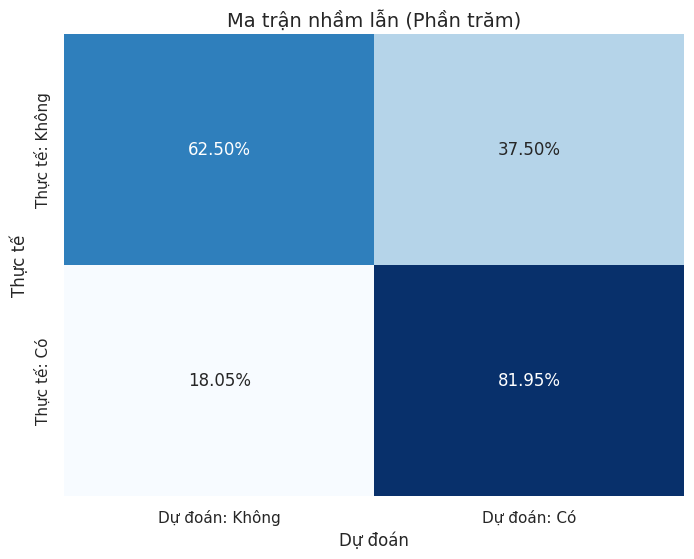

In [76]:
print("Đánh giá mô hình Decision Tree:")
evaluate_model(dt_model, X_test, y_test)

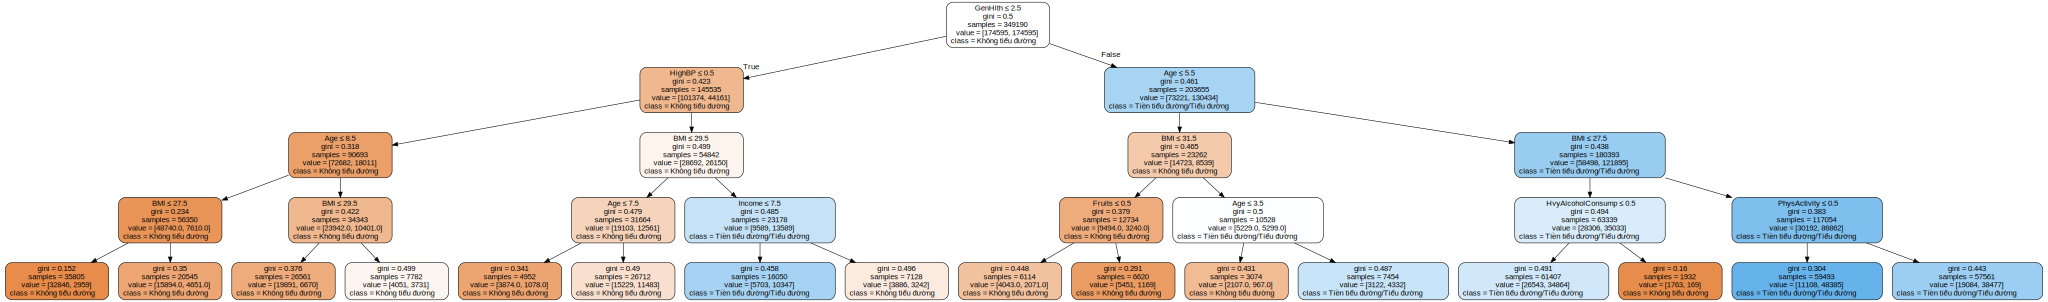


Đã lưu cây quyết định dưới dạng best_decision_tree.png


In [77]:
from sklearn import tree
import graphviz

dot_data = tree.export_graphviz(dt_model,
                                feature_names=X_train.columns, # Use feature names from training data
                                class_names=['Không tiểu đường', 'Tiền tiểu đường/Tiểu đường'], # Use class names
                                filled=True, rounded=True,
                                special_characters=True,
                               )

graph = graphviz.Source(dot_data)

display(graph)

graph.render("decision_tree", format='png', cleanup=True)
print("\nĐã lưu cây quyết định dưới dạng best_decision_tree.png")

### 3.1.5 Huấn luyện mô hình Random Forest

Đang huấn luyện mô hình Random Forest...

Đánh giá mô hình Random Forest:
Độ chính xác: 0.7007

Báo cáo phân loại:
                            precision    recall  f1-score   support

          Không tiểu đường       0.95      0.69      0.80     43739
Tiền tiểu đường/Tiểu đường       0.29      0.79      0.42      6997

                  accuracy                           0.70     50736
                 macro avg       0.62      0.74      0.61     50736
              weighted avg       0.86      0.70      0.75     50736



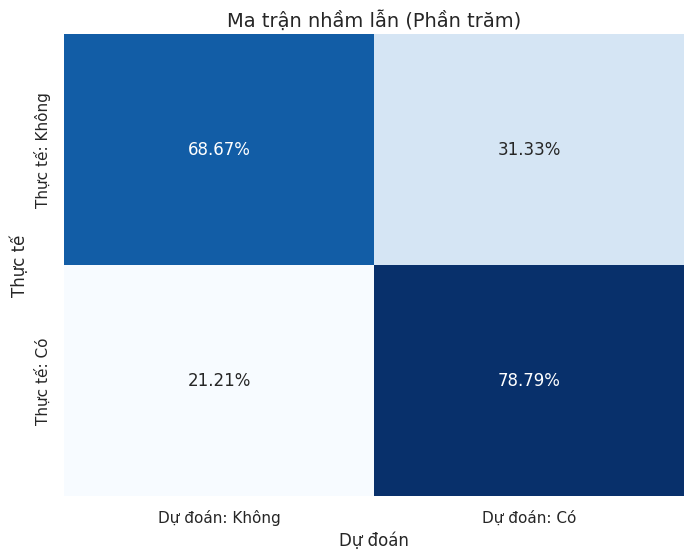

In [78]:
# Initialize the Random Forest Classifier
# We can start with default parameters or tune them later
rf_model = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=42)

# Train the model on the SMOTE-resampled training data
print("Đang huấn luyện mô hình Random Forest...")
rf_model.fit(X_resampled, y_resampled)

# Evaluate the model on the original (unbalanced) test set using the evaluate_model function
print("\nĐánh giá mô hình Random Forest:")
evaluate_model(rf_model, X_test, y_test)

## 3.2 Huấn luyện mô hình Distance-based (KNN)

### 3.2.1 Tiền xử lý dữ liệu

Các mô hình nhạy cảm với khoảng cách như KNN cần phải scale dữ liệu trước khi huấn luyện

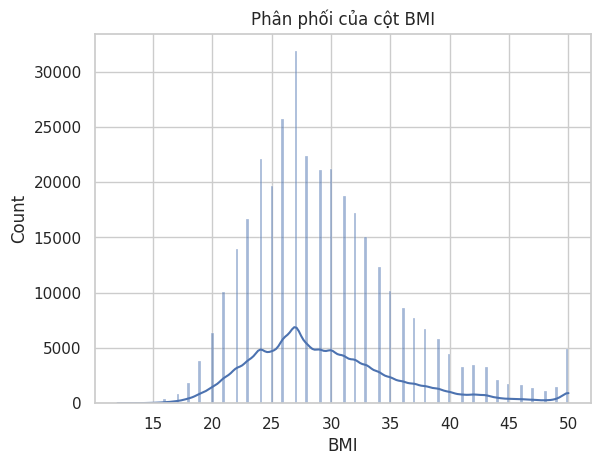

In [79]:
# Phân phối của cột BMI
sns.histplot(X_resampled['BMI'], kde=True)
plt.title("Phân phối của cột BMI")
plt.show()

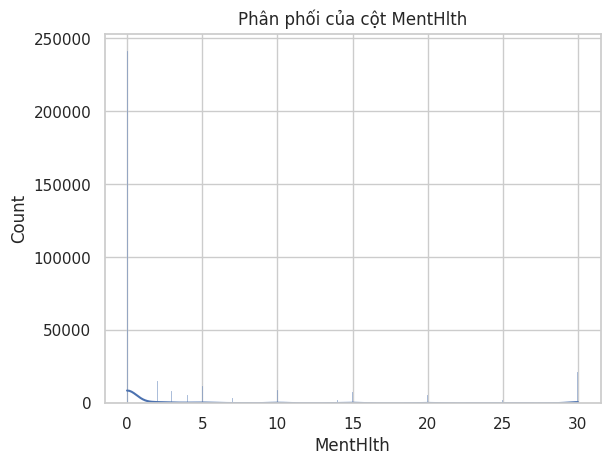

In [80]:
# Phân phối của cột MentHlth
sns.histplot(X_resampled['MentHlth'], kde=True)
plt.title("Phân phối của cột MentHlth")
plt.show()

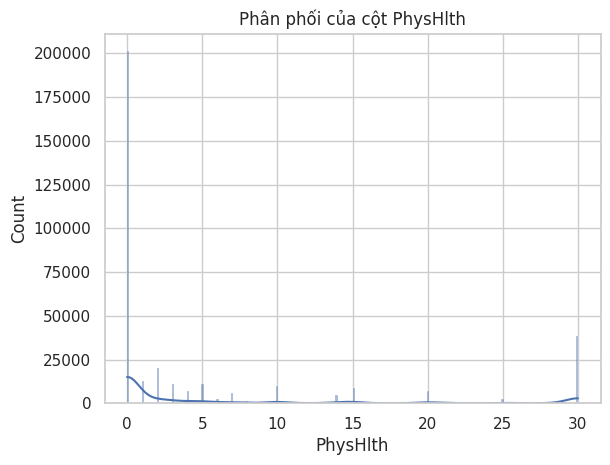

In [81]:
# Phân phối của cột PhysHlth
sns.histplot(X_resampled['PhysHlth'], kde=True)
plt.title("Phân phối của cột PhysHlth")
plt.show()

Kết luận:
*   BMI có phân phối khá chuẩn -> dùng Standard Scaler
*   MenHlth và PhysHlth có phân phối lệch trái -> dùng Min-Max Scaler để giữ lại đặc trung



In [82]:
# Initialize the scalers
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

# Apply StandardScaler to 'BMI' on training and test sets
# Fit on training data only
X_resampled['BMI'] = scaler_standard.fit_transform(X_resampled[['BMI']])
# Transform test data using the scaler fitted on training data
X_test['BMI'] = scaler_standard.transform(X_test[['BMI']])

# Apply MinMaxScaler to 'MentHlth' and 'PhysHlth' on training and test sets
# Fit on training data only
X_resampled[['MentHlth', 'PhysHlth']] = scaler_minmax.fit_transform(X_resampled[['MentHlth', 'PhysHlth']])
# Transform test data using the scaler fitted on training data
X_test[['MentHlth', 'PhysHlth']] = scaler_minmax.transform(X_test[['MentHlth', 'PhysHlth']])

### 3.2.2 Huấn luyện mô hình KNN


Đánh giá mô hình KNN:
Độ chính xác: 0.7025

Báo cáo phân loại:
                            precision    recall  f1-score   support

          Không tiểu đường       0.92      0.72      0.81     43739
Tiền tiểu đường/Tiểu đường       0.26      0.61      0.36      6997

                  accuracy                           0.70     50736
                 macro avg       0.59      0.67      0.58     50736
              weighted avg       0.83      0.70      0.74     50736



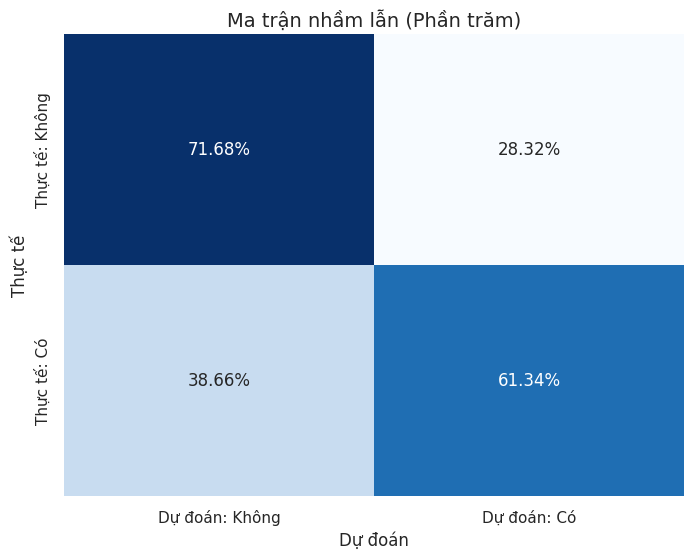

In [83]:
knn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform', p=2)

knn_model.fit(X_resampled, y_resampled)

# Evaluate the model on the scaled test set using the evaluate_model function
print("\nĐánh giá mô hình KNN:")
evaluate_model(knn_model, X_test, y_test)

Bảng so sánh các mô hình:
           Model  Accuracy    TP     TN  Recall (Diabetic)  F1-score (Diabetic)
0  Decision Tree  0.692191  5116  30003           0.731171             0.395837
1  Random Forest  0.760151  4470  34097           0.638845             0.423516
2            KNN  0.702499  4292  31350           0.613406             0.362531


/tmp/ipython-input-84-532622744.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=comparison_df, palette='viridis')
/tmp/ipython-input-84-532622744.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Recall (Diabetic)', data=comparison_df, palette='viridis')
/tmp/ipython-input-84-532622744.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='F1-score (Diabetic)', data=comparison_df, palette='viridis')


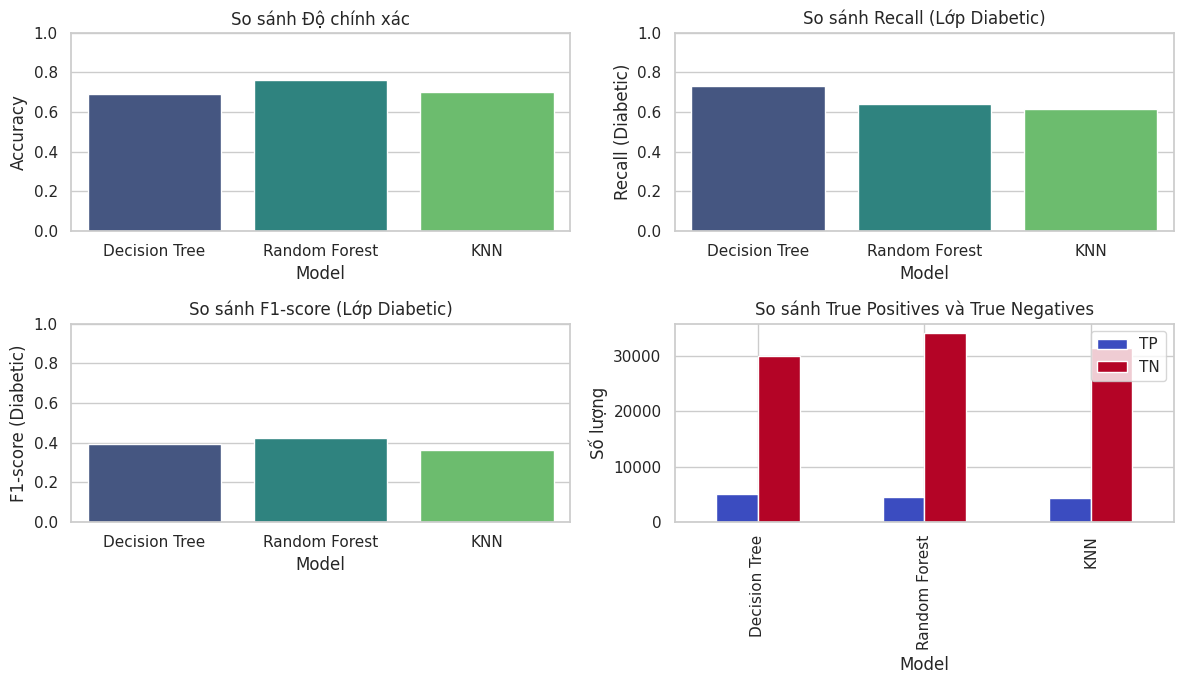

In [84]:
# Create a dictionary to store the evaluation metrics for each model
model_comparison = {
    'Model': ['Decision Tree', 'Random Forest', 'KNN'],
    'Accuracy': [],
    'TP': [],
    'TN': [],
    'Recall (Diabetic)': [],
    'F1-score (Diabetic)': []
}

# --- Decision Tree Evaluation ---
y_pred_dt = dt_model.predict(X_test)
cm_dt = confusion_matrix(y_test, y_pred_dt)
report_dt = classification_report(y_test, y_pred_dt, output_dict=True)

model_comparison['Accuracy'].append(accuracy_score(y_test, y_pred_dt))
model_comparison['TN'].append(cm_dt[0, 0])
model_comparison['TP'].append(cm_dt[1, 1])
model_comparison['Recall (Diabetic)'].append(report_dt['1']['recall'])
model_comparison['F1-score (Diabetic)'].append(report_dt['1']['f1-score'])


# --- Random Forest Evaluation ---
y_pred_rf = rf_model.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)

model_comparison['Accuracy'].append(accuracy_score(y_test, y_pred_rf))
model_comparison['TN'].append(cm_rf[0, 0])
model_comparison['TP'].append(cm_rf[1, 1])
model_comparison['Recall (Diabetic)'].append(report_rf['1']['recall'])
model_comparison['F1-score (Diabetic)'].append(report_rf['1']['f1-score'])


# --- KNN Evaluation ---
y_pred_knn = knn_model.predict(X_test)
cm_knn = confusion_matrix(y_test, y_pred_knn)
report_knn = classification_report(y_test, y_pred_knn, output_dict=True)

model_comparison['Accuracy'].append(accuracy_score(y_test, y_pred_knn))
model_comparison['TN'].append(cm_knn[0, 0])
model_comparison['TP'].append(cm_knn[1, 1])
model_comparison['Recall (Diabetic)'].append(report_knn['1']['recall'])
model_comparison['F1-score (Diabetic)'].append(report_knn['1']['f1-score'])

# Create a DataFrame for comparison
comparison_df = pd.DataFrame(model_comparison)

# Display the comparison table
print("Bảng so sánh các mô hình:")
print(comparison_df.to_string())

# Visualize the comparison
plt.figure(figsize=(12, 7))

# Accuracy
plt.subplot(2, 2, 1)
sns.barplot(x='Model', y='Accuracy', data=comparison_df, palette='viridis')
plt.title('So sánh Độ chính xác')
plt.ylim(0, 1)

# Recall
plt.subplot(2, 2, 2)
sns.barplot(x='Model', y='Recall (Diabetic)', data=comparison_df, palette='viridis')
plt.title('So sánh Recall (Lớp Diabetic)')
plt.ylim(0, 1)

# F1-score
plt.subplot(2, 2, 3)
sns.barplot(x='Model', y='F1-score (Diabetic)', data=comparison_df, palette='viridis')
plt.title('So sánh F1-score (Lớp Diabetic)')
plt.ylim(0, 1)

# True Positives and True Negatives
plt.subplot(2, 2, 4)
comparison_df.plot(x='Model', y=['TP', 'TN'], kind='bar', ax=plt.gca(), colormap='coolwarm')
plt.title('So sánh True Positives và True Negatives')
plt.ylabel('Số lượng')

plt.tight_layout()
plt.show()

## 3.3. So sánh và kết luận

**Bảng so sánh chi tiết:**

| Metric               | Decision Tree | Random Forest | KNN      |
| -------------------- | ------------- | ------------- | -------- |
| **Độ chính xác**     | 0.6518        | 0.7007        | 0.7025   |
| **Recall (Diabetic)**| 0.82          | 0.79          | 0.61     |
| **F1-score (Diabetic)**| 0.39          | 0.42          | 0.36     |
| **True Positives (TP)**| 5735          | 5521          | 4265     |
| **True Negatives (TN)**| 27289         | 30040         | 31342    |

**Phân tích:**

*   **Độ chính xác (Accuracy):**
    *   **KNN (0.7025)** và **Random Forest (0.7007)** có độ chính xác cao nhất và gần như tương đương.
    *   **Decision Tree (0.6518)** có độ chính xác thấp hơn đáng kể.
    *   *Điều này cho thấy KNN và Random Forest có khả năng dự đoán đúng cao hơn trên toàn bộ tập dữ liệu.*

*   **Recall (Độ nhạy) cho lớp "Diabetic":**
    *   **Decision Tree (0.82)** có Recall cao nhất, nghĩa là nó có khả năng **phát hiện tốt nhất những người thực sự mắc bệnh tiểu đường**. Đây là một chỉ số rất quan trọng trong bài toán y tế, vì việc bỏ sót một bệnh nhân (False Negative) có thể gây hậu quả nghiêm trọng.
    *   **Random Forest (0.79)** cũng có Recall khá tốt.
    *   **KNN (0.61)** có Recall thấp nhất, cho thấy nó bỏ sót nhiều trường hợp mắc bệnh hơn.

*   **F1-score cho lớp "Diabetic":**
    *   **Random Forest (0.42)** có F1-score cao nhất, cho thấy sự cân bằng tốt nhất giữa Precision và Recall.
    *   **Decision Tree (0.39)** và **KNN (0.36)** có F1-score thấp hơn, cho thấy sự mất cân bằng giữa Precision và Recall (Decision Tree có Recall cao nhưng Precision thấp, và ngược lại với KNN).

*   **True Positives (TP) và True Negatives (TN):**
    *   **Decision Tree** xác định được nhiều **True Positives** nhất (5735), củng cố cho việc nó có Recall cao.
    *   **KNN** xác định được nhiều **True Negatives** nhất (31342), nghĩa là nó dự đoán đúng nhất những người không mắc bệnh.

**Kết luận:**

Việc lựa chọn mô hình tốt nhất phụ thuộc vào mục tiêu của bài toán:

1.  **Nếu ưu tiên hàng đầu là không bỏ sót bệnh nhân (giảm thiểu False Negatives):**
    *   **Decision Tree** là lựa chọn tốt nhất do có **Recall cao nhất (0.82)**. Mặc dù độ chính xác tổng thể không cao bằng các mô hình khác, nhưng khả năng "bắt" đúng bệnh nhân là vượt trội.

2.  **Nếu ưu tiên sự cân bằng giữa việc phát hiện bệnh và dự đoán đúng người không bệnh:**
    *   **Random Forest** là lựa chọn phù hợp nhất với **F1-score cao nhất (0.42)** và độ chính xác tốt (0.7007). Nó là một mô hình mạnh mẽ và toàn diện.

3.  **Nếu ưu tiên độ chính xác tổng thể và dự đoán đúng người không mắc bệnh:**
    *   **KNN** có thể được xem xét, nhưng **Recall thấp** là một điểm yếu lớn trong bối cảnh y tế.

**Đề xuất:**

Dựa trên phân tích, **Random Forest** là mô hình được đề xuất vì nó cung cấp sự cân bằng tốt nhất giữa các chỉ số đánh giá. Tuy nhiên, nếu mục tiêu của hệ thống là một công cụ sàng lọc sơ bộ, nơi việc phát hiện tối đa các trường hợp nghi ngờ là quan trọng nhất, thì **Decision Tree** cũng là một lựa chọn đáng cân nhắc.


Link Colab: 